In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join("..")))

## Basic Analysis

In [4]:
import cv2  # type: ignore
import numpy as np


def create_flexible_video_grid(video_paths, output_video_path):
    # Open the videos
    videos = [cv2.VideoCapture(video_path) for video_path in video_paths]

    # Get the video properties
    width = int(videos[0].get(3))
    height = int(videos[0].get(4))
    frames_per_second = int(videos[0].get(5))

    # Calculate the number of rows and columns in the grid
    num_videos = len(video_paths)
    grid_cols = int(np.ceil(np.sqrt(num_videos)))
    grid_rows = int(np.ceil(num_videos / grid_cols))

    # Create a VideoWriter object
    video_writer = cv2.VideoWriter(
        output_video_path,
        cv2.VideoWriter_fourcc(*"mp4v"),
        frames_per_second,
        (width * grid_cols, height * grid_rows),
    )

    while True:
        # Read frames from each video
        frames = [video.read()[1] for video in videos]

        # Break the loop if any of the videos is finished
        if any(frame is None for frame in frames):
            break

        # Resize frames to fit in the grid
        resized_frames = [cv2.resize(frame, (width, height)) for frame in frames]

        # Create an empty canvas for the grid
        grid = np.zeros((height * grid_rows, width * grid_cols, 3), dtype=np.uint8)

        # Arrange the frames in the grid
        for i in range(grid_rows):
            for j in range(grid_cols):
                index = i * grid_cols + j
                if index < num_videos:
                    grid[
                        i * height : (i + 1) * height, j * width : (j + 1) * width, :
                    ] = resized_frames[index]

        # Write the frame to the video
        video_writer.write(grid)

    # Release resources
    for video in videos:
        video.release()
    video_writer.release()

In [5]:
def create_video(image_path, label, output_path, frame_duration=0.3):
    images = [
        image_path + f for f in os.listdir(image_path) if f.startswith(str(label))
    ]
    steps = [int(f.split("_")[1].split(".")[0]) for f in images]
    # sort by step number
    images = [x for _, x in sorted(zip(steps, images))]
    frame = cv2.imread(images[0])
    height, width, layers = frame.shape

    video = cv2.VideoWriter(
        output_path,
        cv2.VideoWriter_fourcc(*"mp4v"),
        1 / frame_duration,
        (width, height),
    )

    for image in images:
        img_path = image
        frame = cv2.imread(img_path)
        video.write(frame)

    cv2.destroyAllWindows()
    video.release()


experiment = "experiment3"
type = "train/"
class_number = 5
log_path = f"../logs/{experiment}/images"
image_path = os.path.join(log_path, type)
videos = []
for label in range(class_number):
    output_path = f"{log_path}/video_{label}.mp4"
    videos.append(output_path)
    create_video(image_path, label, output_path)
grid_video_path = f"{log_path}/grid.mp4"
create_flexible_video_grid(videos, grid_video_path)

In [8]:
topo_cellular_response_path = "/Users/rezachi/Library/Mobile Documents/com~apple~CloudDocs/Business/UK/DRS/Biomaterial/repo/Biomaterial-AI/datasets/topo cellular response/raw/AeruginosaforML.csv"
topo_cellular_response = pd.read_csv(topo_cellular_response_path)
topo_cellular_response.head()

FeatID   Average
0       1  1.762475
1       3  0.204420
2       5  0.230710
3       6  2.008642
4       8  1.957861

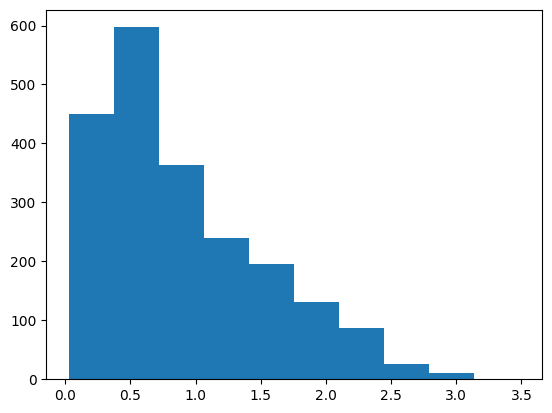

In [9]:
plt.hist(topo_cellular_response["Average"])
plt.show()

In [10]:
# make the average column to 5 classes
topo_cellular_response["Average"] = pd.cut(
    topo_cellular_response["Average"], bins=5, labels=[0, 1, 2, 3, 4]
)
topo_cellular_response.head()

FeatID Average
0       1       2
1       3       0
2       5       0
3       6       2
4       8       2

In [11]:
# save the new csv
topo_cellular_response.to_csv(
    "/Users/rezachi/Library/Mobile Documents/com~apple~CloudDocs/Business/UK/DRS/Biomaterial/repo/Biomaterial-AI/datasets/topo cellular response/raw/AeruginosaforML_5classes.csv",
    index=False,
)

## Image Interpolation

In [8]:
from scipy.ndimage import distance_transform_edt
from scipy.interpolate import interpn

def ndgrid(*args,**kwargs):
    """
    Same as calling ``meshgrid`` with *indexing* = ``'ij'`` (see
    ``meshgrid`` for documentation).
    """
    kwargs['indexing'] = 'ij'
    return np.meshgrid(*args,**kwargs)

def bwperim(bw, n=4):
    """
    perim = bwperim(bw, n=4)
    Find the perimeter of objects in binary images.
    A pixel is part of an object perimeter if its value is one and there
    is at least one zero-valued pixel in its neighborhood.
    By default the neighborhood of a pixel is 4 nearest pixels, but
    if `n` is set to 8 the 8 nearest pixels will be considered.
    Parameters
    ----------
      bw : A black-and-white image
      n : Connectivity. Must be 4 or 8 (default: 8)
    Returns
    -------
      perim : A boolean image

    From Mahotas: http://nullege.com/codes/search/mahotas.bwperim
    """

    if n not in (4,8):
        raise ValueError('mahotas.bwperim: n must be 4 or 8')
    rows,cols = bw.shape

    # Translate image by one pixel in all directions
    north = np.zeros((rows,cols))
    south = np.zeros((rows,cols))
    west = np.zeros((rows,cols))
    east = np.zeros((rows,cols))

    north[:-1,:] = bw[1:,:]
    south[1:,:]  = bw[:-1,:]
    west[:,:-1]  = bw[:,1:]
    east[:,1:]   = bw[:,:-1]
    idx = (north == bw) & \
          (south == bw) & \
          (west  == bw) & \
          (east  == bw)
    if n == 8:
        north_east = np.zeros((rows, cols))
        north_west = np.zeros((rows, cols))
        south_east = np.zeros((rows, cols))
        south_west = np.zeros((rows, cols))
        north_east[:-1, 1:]   = bw[1:, :-1]
        north_west[:-1, :-1] = bw[1:, 1:]
        south_east[1:, 1:]     = bw[:-1, :-1]
        south_west[1:, :-1]   = bw[:-1, 1:]
        idx &= (north_east == bw) & \
               (south_east == bw) & \
               (south_west == bw) & \
               (north_west == bw)
    return ~idx * bw

def signed_bwdist(im):
    '''
    Find perim and return masked image (signed/reversed)
    '''    
    im = -bwdist(bwperim(im))*np.logical_not(im) + bwdist(bwperim(im))*im
    return im

def bwdist(im):
    '''
    Find distance map of image
    '''
    dist_im = distance_transform_edt(1-im)
    return dist_im

def interp_shape(top, bottom, precision):
    '''
    Interpolate between two contours

    Input: top 
            [X,Y] - Image of top contour (mask)
           bottom
            [X,Y] - Image of bottom contour (mask)
           precision
             float  - % between the images to interpolate 
                Ex: num=0.5 - Interpolate the middle image between top and bottom image
    Output: out
            [X,Y] - Interpolated image at num (%) between top and bottom

    '''
    if precision>2:
        print("Error: Precision must be between 0 and 1 (float)")

    top = signed_bwdist(top)
    bottom = signed_bwdist(bottom)

    # row,cols definition
    r, c = top.shape

    # Reverse % indexing
    precision = 1+precision

    # rejoin top, bottom into a single array of shape (2, r, c)
    top_and_bottom = np.stack((top, bottom))

    # create ndgrids 
    points = (np.r_[0, 2], np.arange(r), np.arange(c))
    xi = np.rollaxis(np.mgrid[:r, :c], 0, 3).reshape((r**2, 2))
    xi = np.c_[np.full((r**2),precision), xi]

    # Interpolate for new plane
    out = interpn(points, top_and_bottom, xi)
    out = out.reshape((r, c))

    # Threshold distmap to values above 0
    out = out > 0

    return out

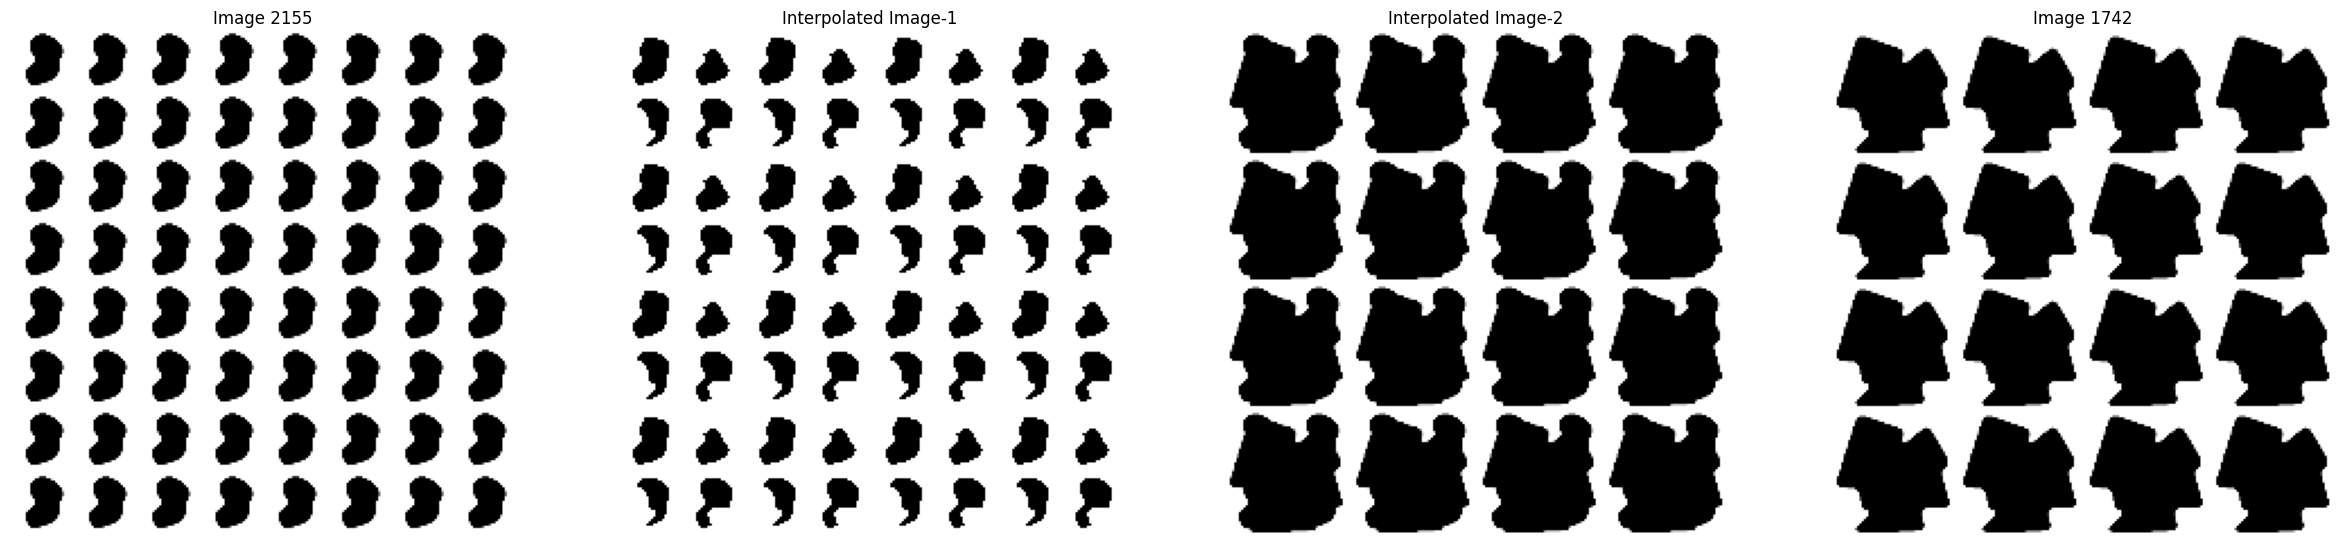

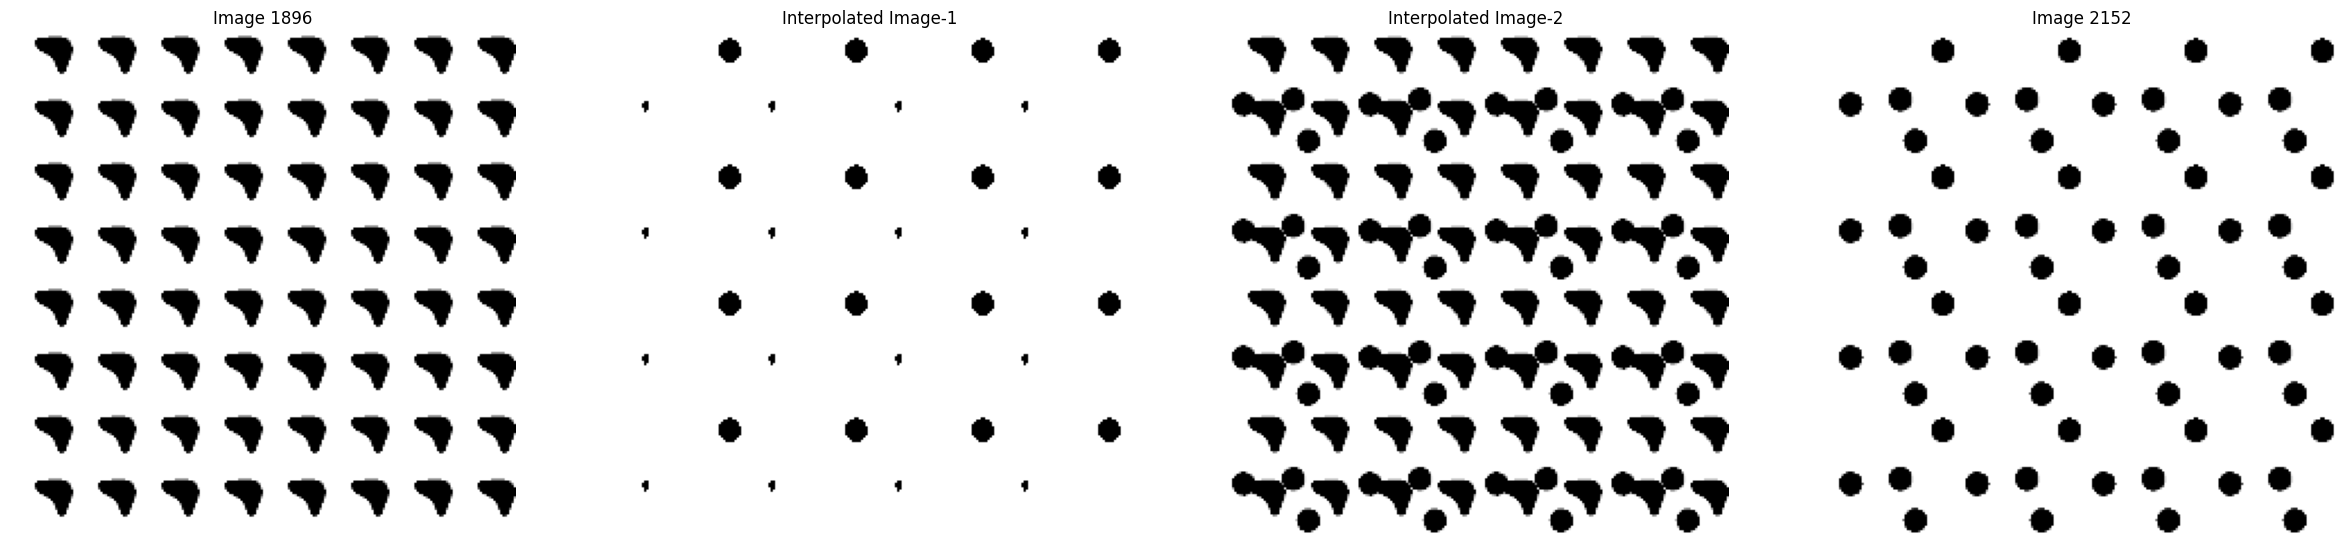

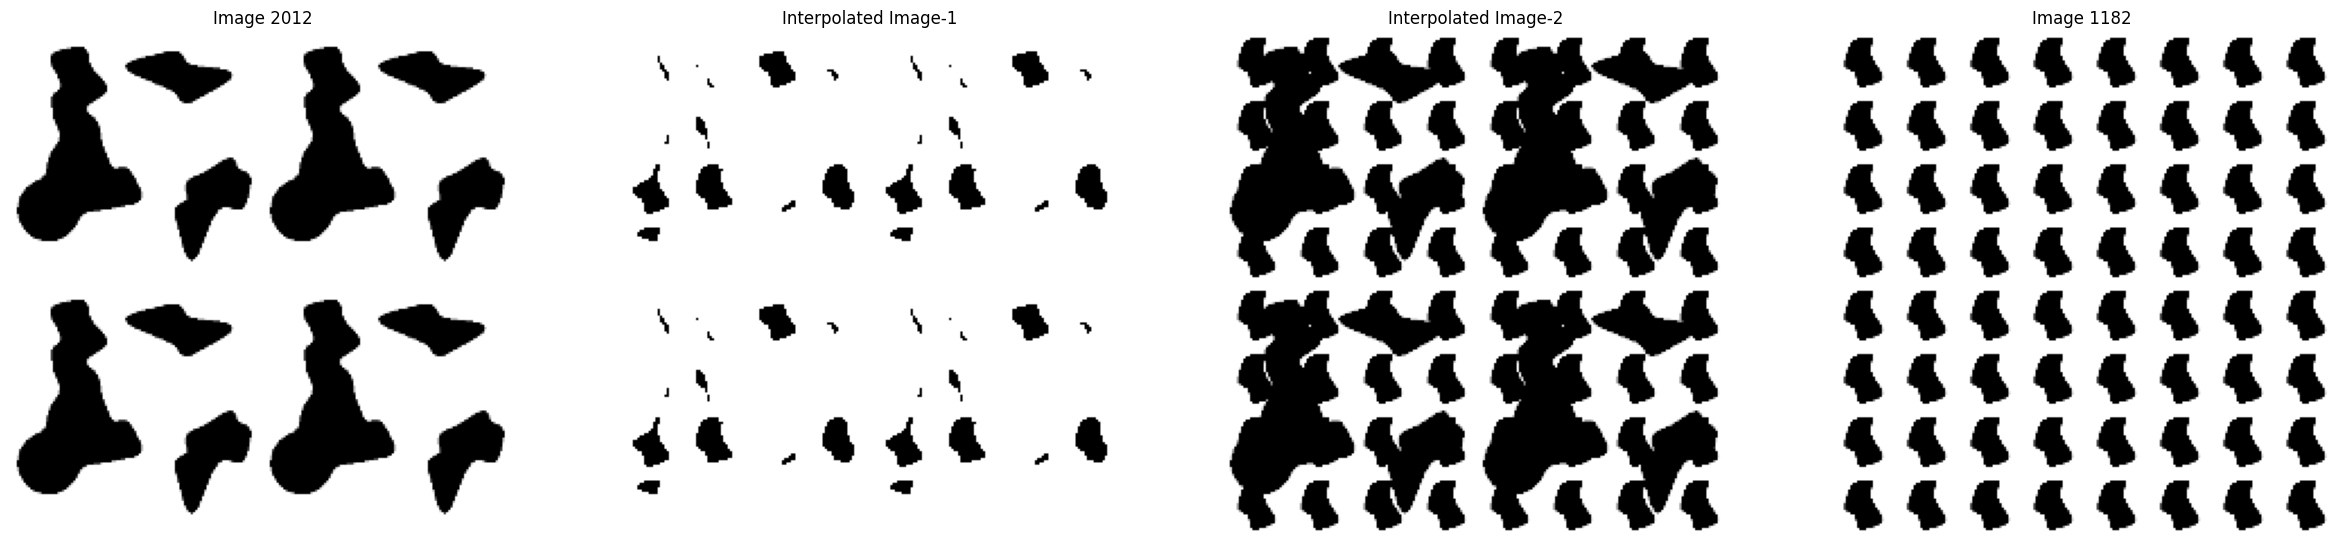

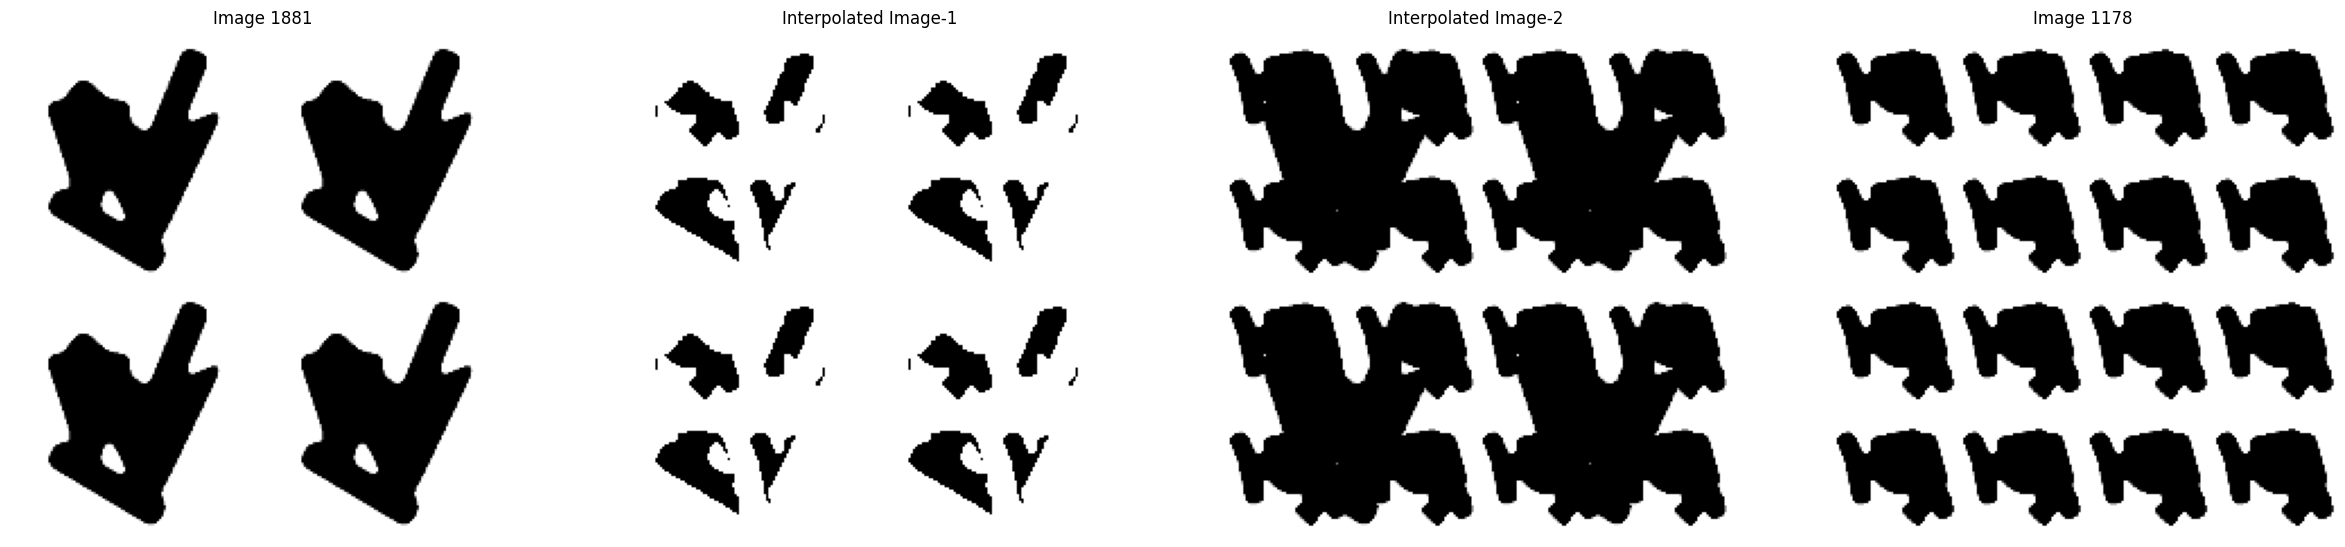

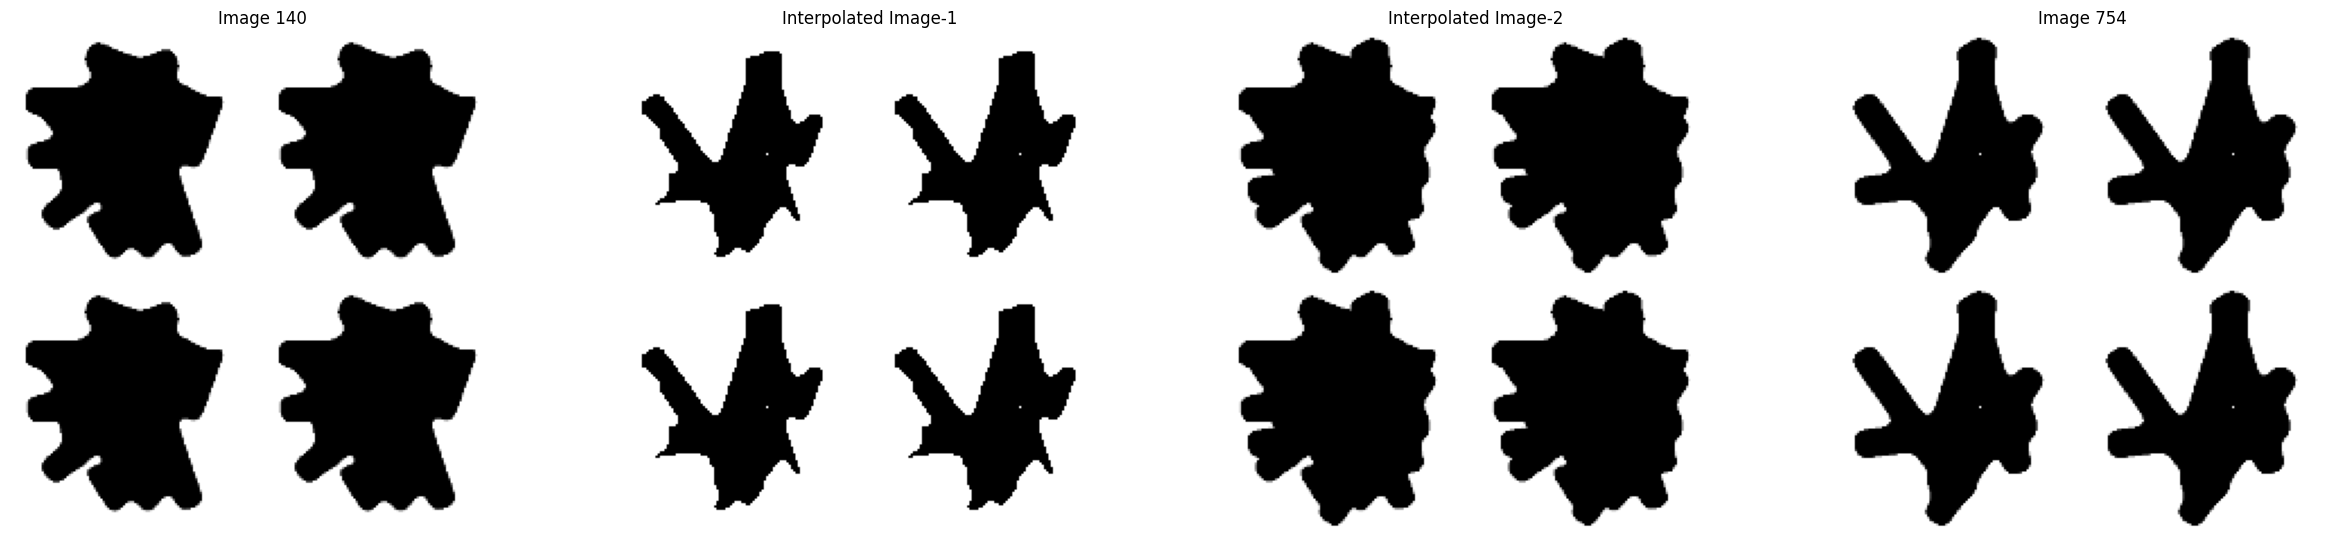

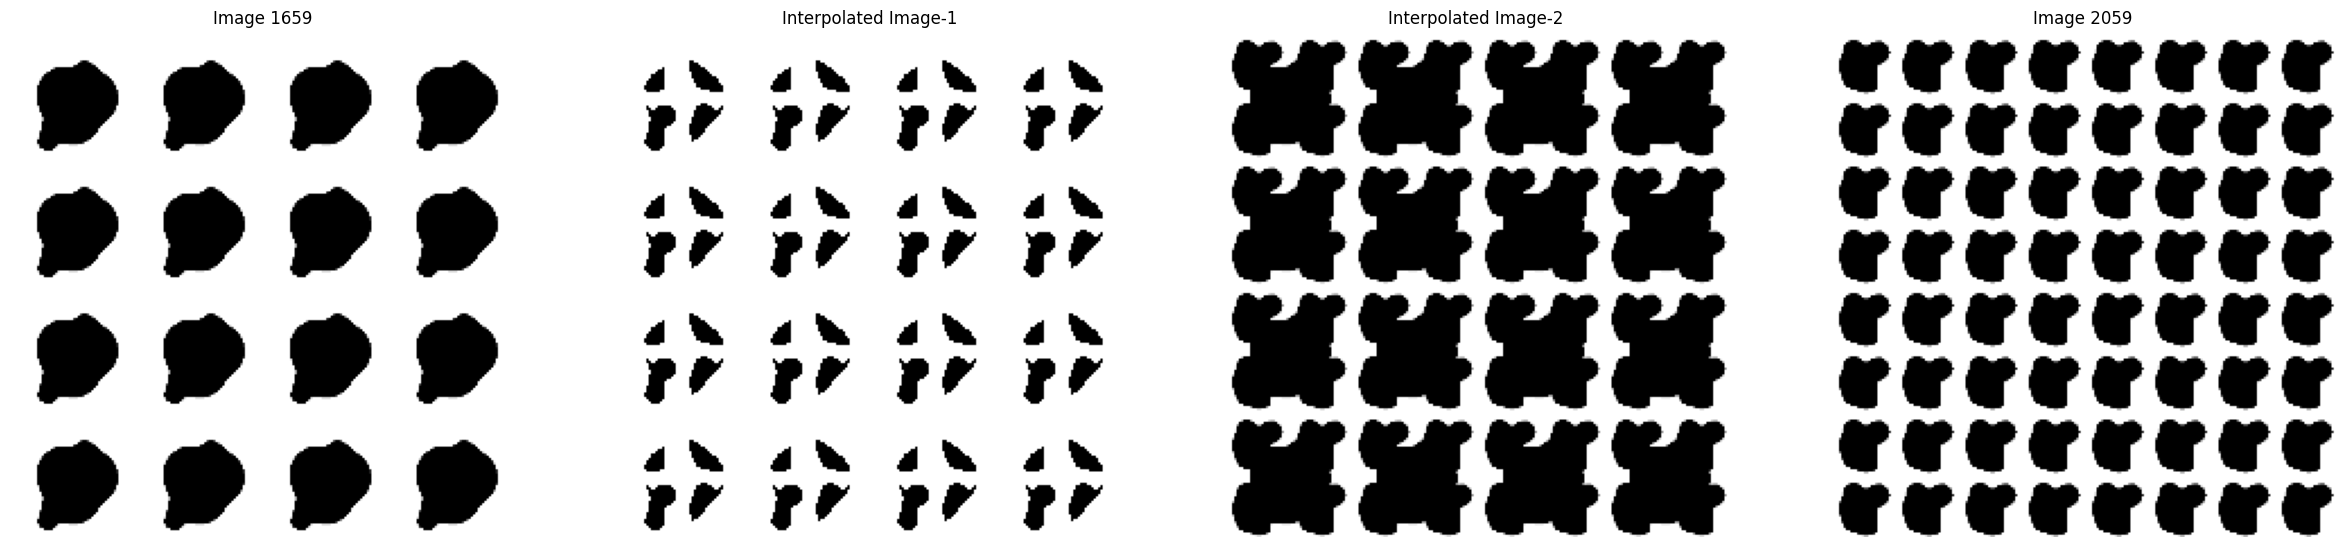

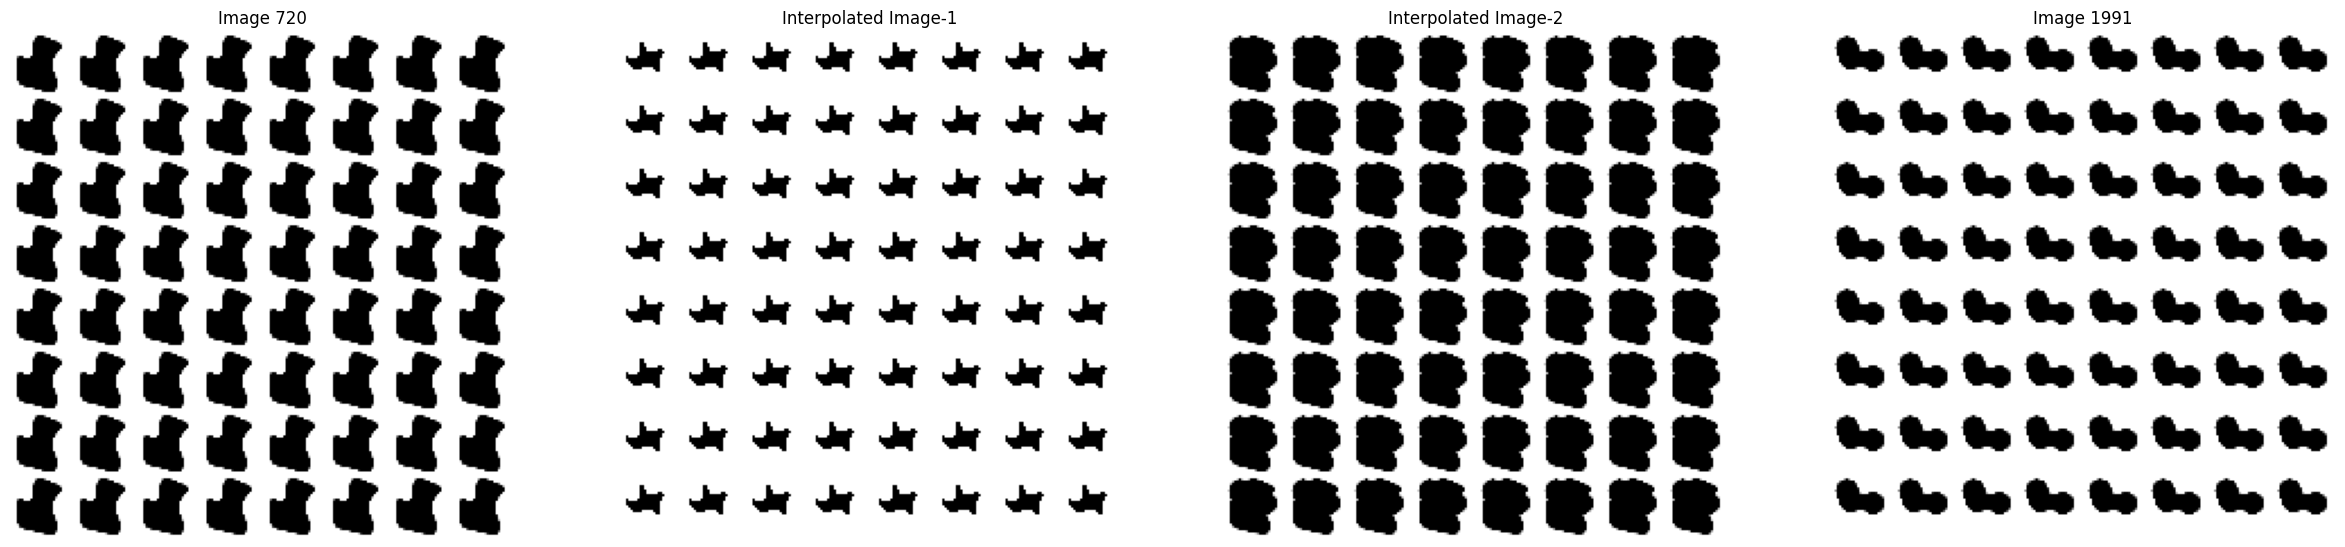

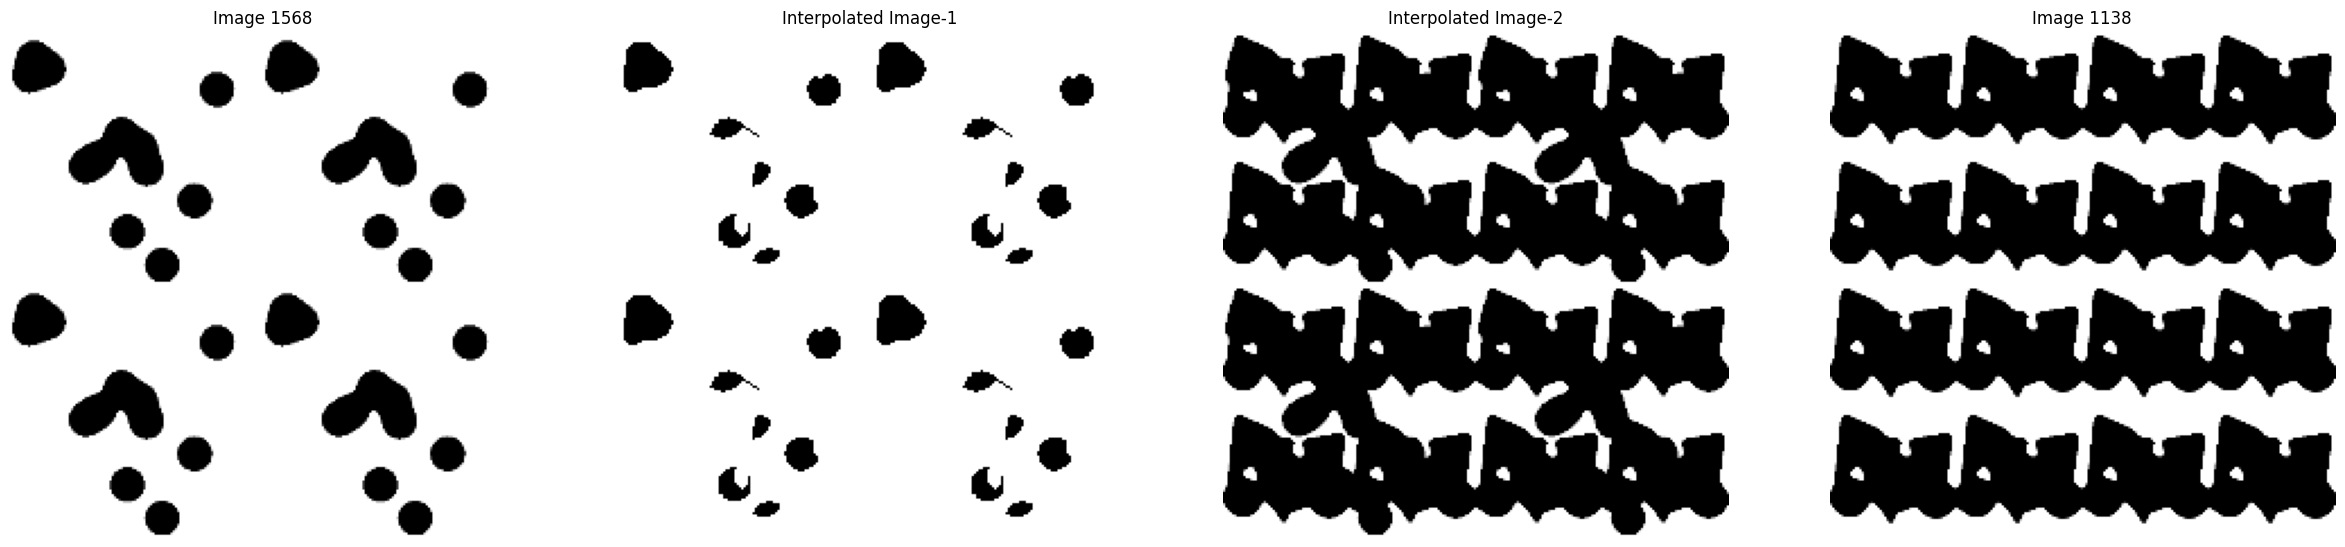

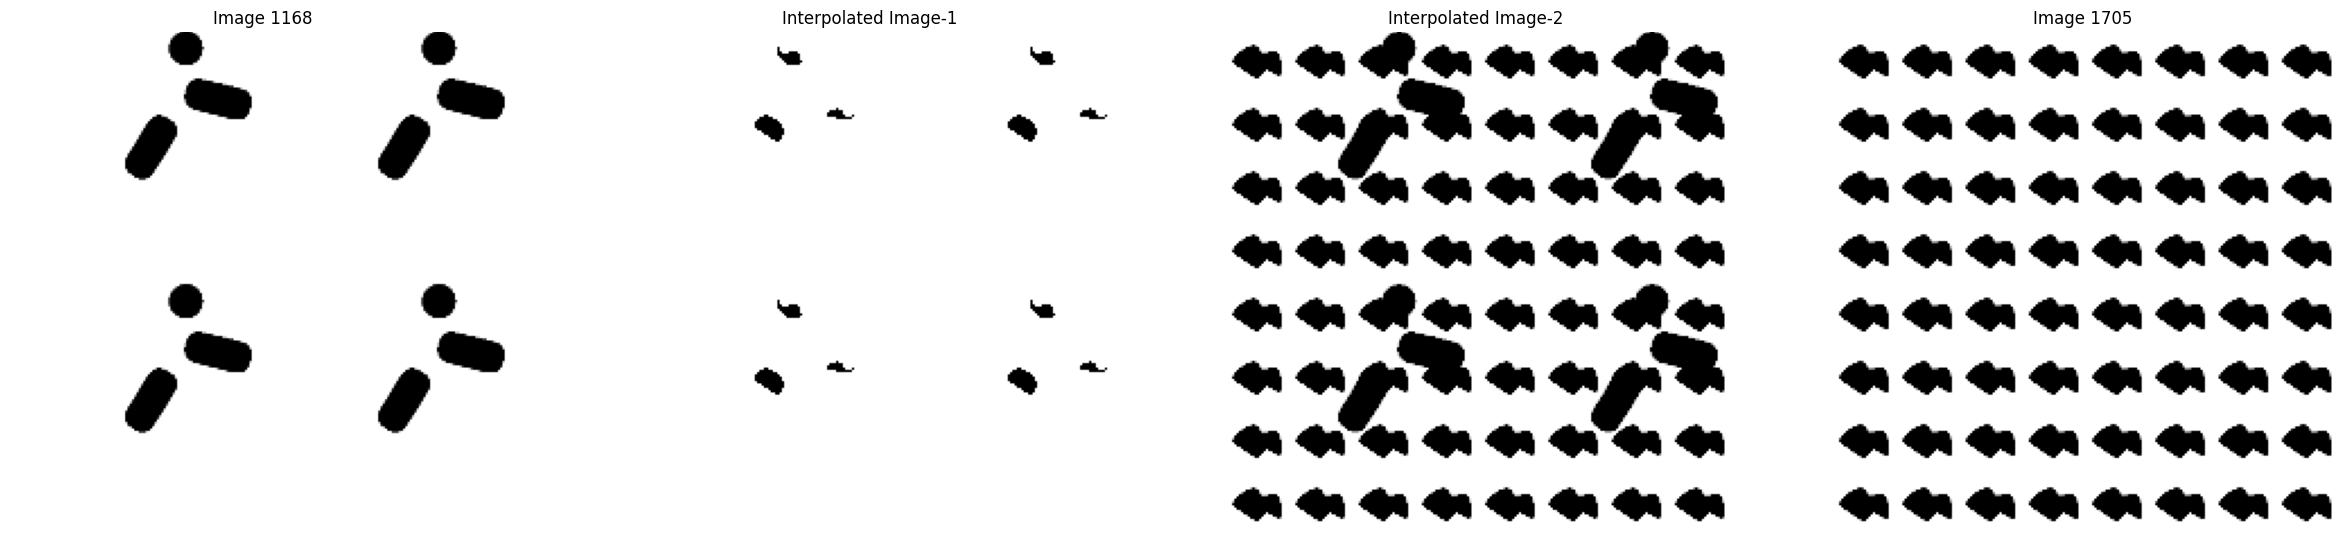

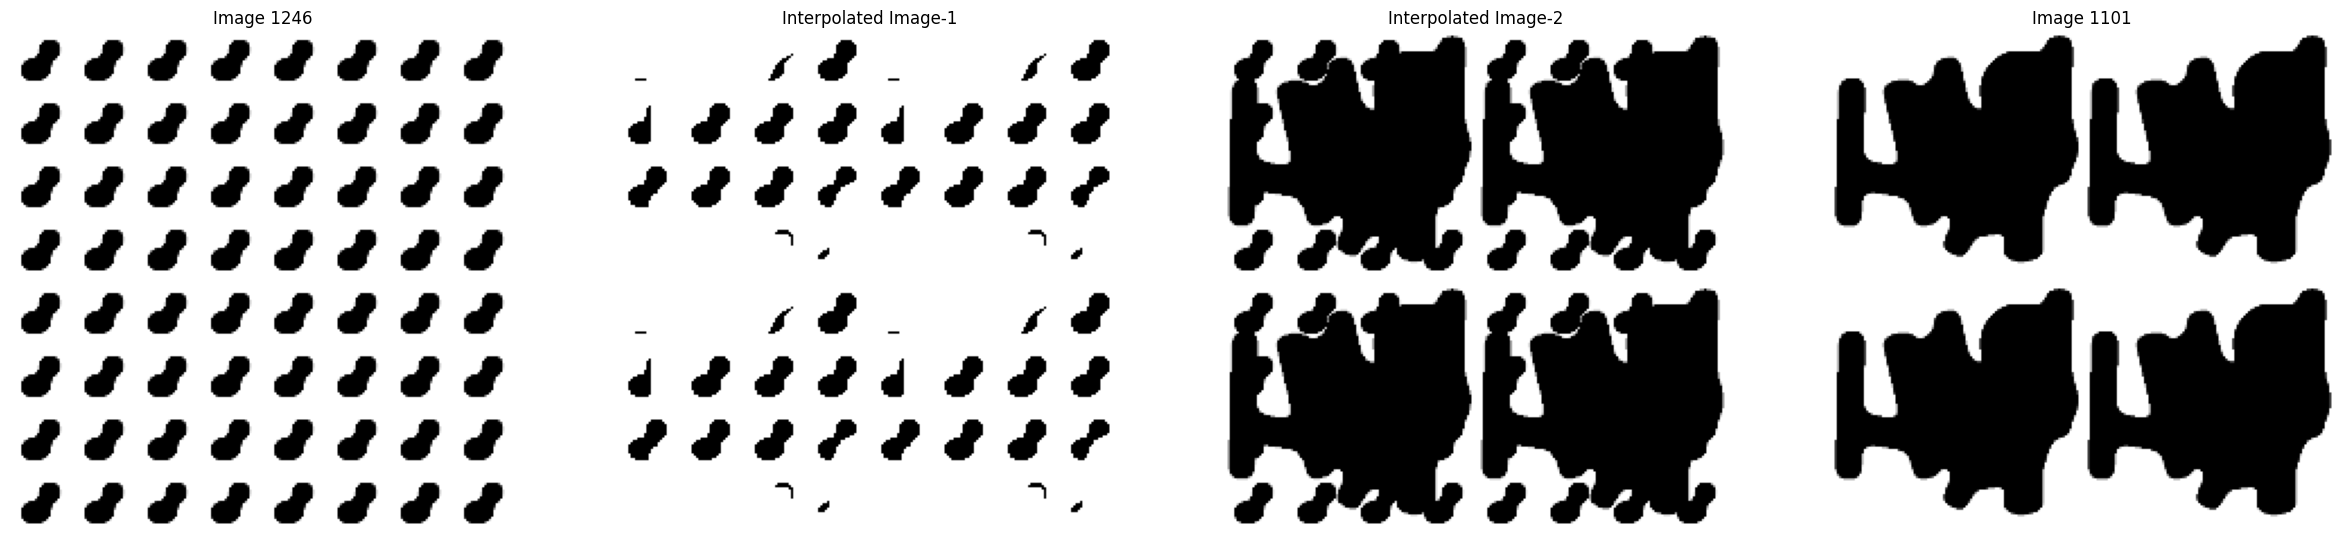

In [9]:
import glob
from pathlib import Path
import os
import random
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import numpy as np


images_path = '/Users/rezachi/Library/Mobile Documents/com~apple~CloudDocs/Business/UK/DRS/Biomaterial/repo/Datasets/Topographies/raw/FiguresStacked 8X8 Embossed'
images_names = [
            Path(image).stem
            for image in glob.glob(
                os.path.join(images_path, "*.png")
            )
        ]

def interpolate_images(image1, image2, alpha):
    # Ensure images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("Both images must have the same dimensions")

    # Interpolate between the two images
    interpolated_image = cv2.addWeighted(image1, alpha, image2, 1-alpha, 0)

    return interpolated_image

def intersection_interp(image1, image2, alpha):
    # Ensure images have the same dimensions
    assert image1.shape == image2.shape, "Images must have the same dimensions"

    _, binary_image1 = cv2.threshold(image1, 0.5, 1, cv2.THRESH_BINARY)
    _, binary_image2 = cv2.threshold(image2, 0.5, 1, cv2.THRESH_BINARY)

    # Create a mask of overlapping regions
    overlap_mask = cv2.bitwise_and(binary_image1, binary_image2)

    # Interpolate between the images
    interpolated_image = cv2.addWeighted(image1, 1 - alpha, image2, alpha, 0)

    # Apply the overlap mask to the interpolated image
    interpolated_image = interpolated_image * overlap_mask

    return interpolated_image

n_images = 10
img_size = 224
alpha = 0.5
seed = 1221
random.seed(seed)
np.random.seed(seed)

for i in range(n_images):
    # generate two random indices
    idx1, idx2 = np.random.choice(len(images_names), 2, replace=False)
    
    # load the images
    img1 = cv2.imread(os.path.join(images_path, f"{images_names[idx1]}.png"), cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(os.path.join(images_path, f"{images_names[idx2]}.png"), cv2.IMREAD_GRAYSCALE)

    # resize the images
    img1 = cv2.resize(img1, (img_size, img_size))
    img2 = cv2.resize(img2, (img_size, img_size))
    
    # interpolate the images
    # interpolated_image = interpolate_images(img1, img2, alpha)
    interpolated_image1 = interp_shape(img1, img2, alpha)
    interpolated_image2 = intersection_interp(img1, img2, alpha)


    # plot the images
    plt.figure(figsize=(30, 30))
    plt.subplot(1, 4, 1)
    plt.imshow(img1, cmap="gray")
    plt.title(f"Image {idx1}")
    plt.axis("off")
    plt.subplot(1, 4, 2)
    plt.imshow(interpolated_image1, cmap="gray")
    plt.title("Interpolated Image-1")
    plt.axis("off")
    plt.subplot(1, 4, 3)
    plt.imshow(interpolated_image2, cmap="gray")
    plt.title("Interpolated Image-2")
    plt.axis("off")
    plt.subplot(1, 4, 4)
    plt.imshow(img2, cmap="gray")
    plt.title(f"Image {idx2}")
    plt.axis("off")
    plt.show()


In [ ]:
import glob
from pathlib import Path
import os
import random
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist

# load the MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

def interpolate_images(image1, image2, alpha):
    # Ensure images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("Both images must have the same dimensions")

    # Interpolate between the two images
    interpolated_image = cv2.addWeighted(image1, alpha, image2, 1-alpha, 0)

    return interpolated_image

def intersection_interp(image1, image2, alpha):
    # Ensure images have the same dimensions
    assert image1.shape == image2.shape, "Images must have the same dimensions"

    _, binary_image1 = cv2.threshold(image1, 0.5, 1, cv2.THRESH_BINARY)
    _, binary_image2 = cv2.threshold(image2, 0.5, 1, cv2.THRESH_BINARY)

    # Create a mask of overlapping regions
    overlap_mask = cv2.bitwise_and(binary_image1, binary_image2)

    # Interpolate between the images
    interpolated_image = cv2.addWeighted(image1, 1 - alpha, image2, alpha, 0)

    # Apply the overlap mask to the interpolated image
    interpolated_image = interpolated_image * overlap_mask

    return interpolated_image

n_images = 10
img_size = 28
alpha = 0.5
seed = 1221
random.seed(seed)
np.random.seed(seed)

for i in range(n_images):
    # generate two random indices
    idx1, idx2 = np.random.choice(len(train_images), 2, replace=False)
    
    # load the images
    img1 = train_images[idx1]
    img2 = train_images[idx2]
    
    # interpolate the images
    # interpolated_image = interpolate_images(img1, img2, alpha)
    interpolated_image1 = interp_shape(img1, img2, alpha)
    interpolated_image2 = intersection_interp(img1, img2, alpha)


    # plot the images
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(img1, cmap="gray")
    plt.title(f"Image {idx1}")
    plt.axis("off")
    plt.subplot(1, 4, 2)
    plt.imshow(interpolated_image1, cmap="gray")
    plt.title("Interpolated Image-1")
    plt.axis("off")
    plt.subplot(1, 4, 3)
    plt.imshow(interpolated_image2, cmap="gray")
    plt.title("Interpolated Image-2")
    plt.axis("off")
    plt.subplot(1, 4, 4)
    plt.imshow(img2, cmap="gray")
    plt.title(f"Image {idx2}")
    plt.axis("off")
    plt.show()


## Dimensionality Reduction

### PCA

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
import os
import random
import cv2
import glob
from pathlib import Path

images_path = '/Users/rezachi/Library/Mobile Documents/com~apple~CloudDocs/Business/UK/DRS/Biomaterial/repo/Datasets/Topographies/raw/FiguresStacked 8X8 Embossed'
images_names = [
            Path(image).stem
            for image in glob.glob(
                os.path.join(images_path, "*.png")
            )
        ]
img_size = 224
seed = 1221
random.seed(seed)
np.random.seed(seed)
# Load all of the images and make them as a batch
images = []
for image_name in images_names:
    image = cv2.imread(os.path.join(images_path, f"{image_name}.png"), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (img_size, img_size))
    images.append(image)

images = np.array(images)

# Flatten the images
images = images.reshape(images.shape[0], -1)

steps = [('scaling', StandardScaler()), ('pca', PCA(n_components=2))]
pipeline = Pipeline(steps)
images_pca = pipeline.fit_transform(images)

In [28]:
from turtle import color
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=images_pca[:, 0],
    y=images_pca[:, 1],
    mode='markers',
    marker=dict(size=8),
    marker_color='blue',
    name='Original',
    text=[f"{i}" for i in range(len(images_pca))],
    hoverinfo='text'
))

fig.update_layout(
    title="Images distribution in 2D",
    title_x=0.5,
    xaxis_title="PCA Component 1",
    yaxis_title="PCA Component 2",
    width=1000,
    height=1000,
    xaxis=dict(range=[-200, 230]),
    yaxis=dict(range=[-170, 200]),
)

fig.show()

In [11]:
interp_images = []
n_images = 250
img_size = 224
alpha = 0.5
seed = 1221
random.seed(seed)
np.random.seed(seed)

for i in range(n_images):
    # generate two random indices
    idx1, idx2 = np.random.choice(len(images_names), 2, replace=False)
    
    # load the images
    img1 = cv2.imread(os.path.join(images_path, f"{images_names[idx1]}.png"), cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(os.path.join(images_path, f"{images_names[idx2]}.png"), cv2.IMREAD_GRAYSCALE)

    # resize the images
    img1 = cv2.resize(img1, (img_size, img_size))
    img2 = cv2.resize(img2, (img_size, img_size))
    
    # interpolate the images
    interpolated_image1 = interpolate_images(img1, img2, alpha)
    interpolated_image2 = intersection_interp(img1, img2, alpha)
    interp_images.append(interpolated_image1)
    interp_images.append(interpolated_image2)

interp_images = np.array(interp_images)
interp_images = interp_images.reshape(interp_images.shape[0], -1)

steps = [('scaling', StandardScaler()), ('pca', PCA(n_components=2))]
pipeline = Pipeline(steps)
interp_images_pca = pipeline.fit_transform(interp_images)

In [27]:
from turtle import color
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=images_pca[:, 0],
    y=images_pca[:, 1],
    mode='markers',
    marker=dict(size=8),
    marker_color='blue',
    name='Original',
    text=[f"{i}" for i in range(len(images_pca))],
    hoverinfo='text'
))
fig.add_trace(go.Scatter(
    x=interp_images_pca[:, 0],
    y=interp_images_pca[:, 1],
    mode='markers',
    marker=dict(size=8),
    marker_color='red',
    name='Interpolated',
    text=[f"{i}" for i in range(len(interp_images_pca))],
    hoverinfo='text'
))

fig.update_layout(
    title="Images distribution in 2D",
    title_x=0.5,
    xaxis_title="PCA Component 1",
    yaxis_title="PCA Component 2",
    width=1000,
    height=1000,
    xaxis=dict(range=[-200, 230]),
    yaxis=dict(range=[-170, 200]),
)

fig.show()

In [33]:
images_path = '/Users/rezachi/Library/CloudStorage/OneDrive-TheUniversityofNottingham/Biomaterial/GAN results/logs/experiment23_WGAN_GP_embossed/images/train'
images_names = [
            Path(image).stem
            for image in glob.glob(
                os.path.join(images_path, "*.png")
            ) if int(Path(image).stem.split("_")[1]) >= 8000
        ]
img_size = 224
seed = 1221
random.seed(seed)
np.random.seed(seed)
# Load all of the images and make them as a batch
GAN_images = []
for image_name in images_names:
    image = cv2.imread(os.path.join(images_path, f"{image_name}.png"), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (img_size, img_size))
    GAN_images.append(image)

GAN_images = np.array(GAN_images)

# Flatten the images
GAN_images = GAN_images.reshape(GAN_images.shape[0], -1)

steps = [('scaling', StandardScaler()), ('pca', PCA(n_components=2))]
pipeline = Pipeline(steps)
GAN_images_pca = pipeline.fit_transform(GAN_images)

In [29]:
from turtle import color
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=images_pca[:, 0],
    y=images_pca[:, 1],
    mode='markers',
    marker=dict(size=8),
    marker_color='blue',
    name='Original',
    text=[f"{i}" for i in range(len(images_pca))],
    hoverinfo='text'
))
fig.add_trace(go.Scatter(
    x=interp_images_pca[:, 0],
    y=interp_images_pca[:, 1],
    mode='markers',
    marker=dict(size=8),
    marker_color='red',
    name='Interpolated',
    text=[f"{i}" for i in range(len(interp_images_pca))],
    hoverinfo='text'
))
fig.add_trace(go.Scatter(
    x=GAN_images_pca[:, 0],
    y=GAN_images_pca[:, 1],
    mode='markers',
    marker=dict(size=10),
    marker_color='black',
    name='WGAN',
    text=[f"{i}" for i in range(len(GAN_images_pca))],
    hoverinfo='text',
))

fig.update_layout(
    title="Images distribution in 2D",
    title_x=0.5,
    xaxis_title="PCA Component 1",
    yaxis_title="PCA Component 2",
    width=1000,
    height=1000,
    xaxis=dict(range=[-200, 230]),
    yaxis=dict(range=[-170, 200]),
)

fig.show()

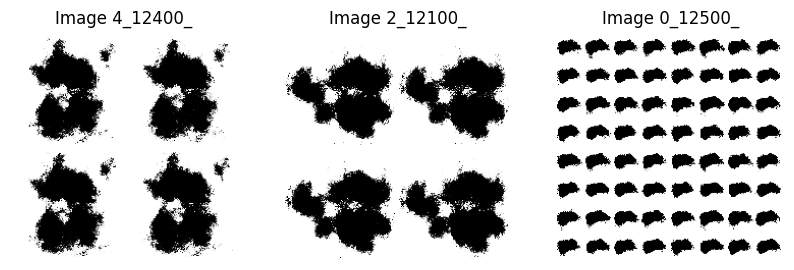

In [35]:
indexes = [230, 204, 241]
images_path = '/Users/rezachi/Library/CloudStorage/OneDrive-TheUniversityofNottingham/Biomaterial/GAN results/logs/experiment23_WGAN_GP_embossed/images/train'
images_names = [
            Path(image).stem
            for image in glob.glob(
                os.path.join(images_path, "*.png")
            ) if int(Path(image).stem.split("_")[1]) >= 8000
        ]
images = [images_names[i] for i in indexes]

plt.figure(figsize=(10, 10))
for i, image in enumerate(images):
    img = cv2.imread(os.path.join(images_path, f"{image}.png"), cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Image {image}")
    plt.axis("off")
plt.show()

### MNIST

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
import os
import random
import cv2
import glob
from pathlib import Path
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# load the MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

img_size = 28
seed = 1221
random.seed(seed)
np.random.seed(seed)
# Load all of the images and make them as a batch
mnist_images = np.array(train_images)

# Flatten the images
mnist_images = mnist_images.reshape(mnist_images.shape[0], -1)

steps = [('scaling', StandardScaler()), ('pca', PCA(n_components=2))]
pipeline = Pipeline(steps)
mnist_images_pca = pipeline.fit_transform(mnist_images)

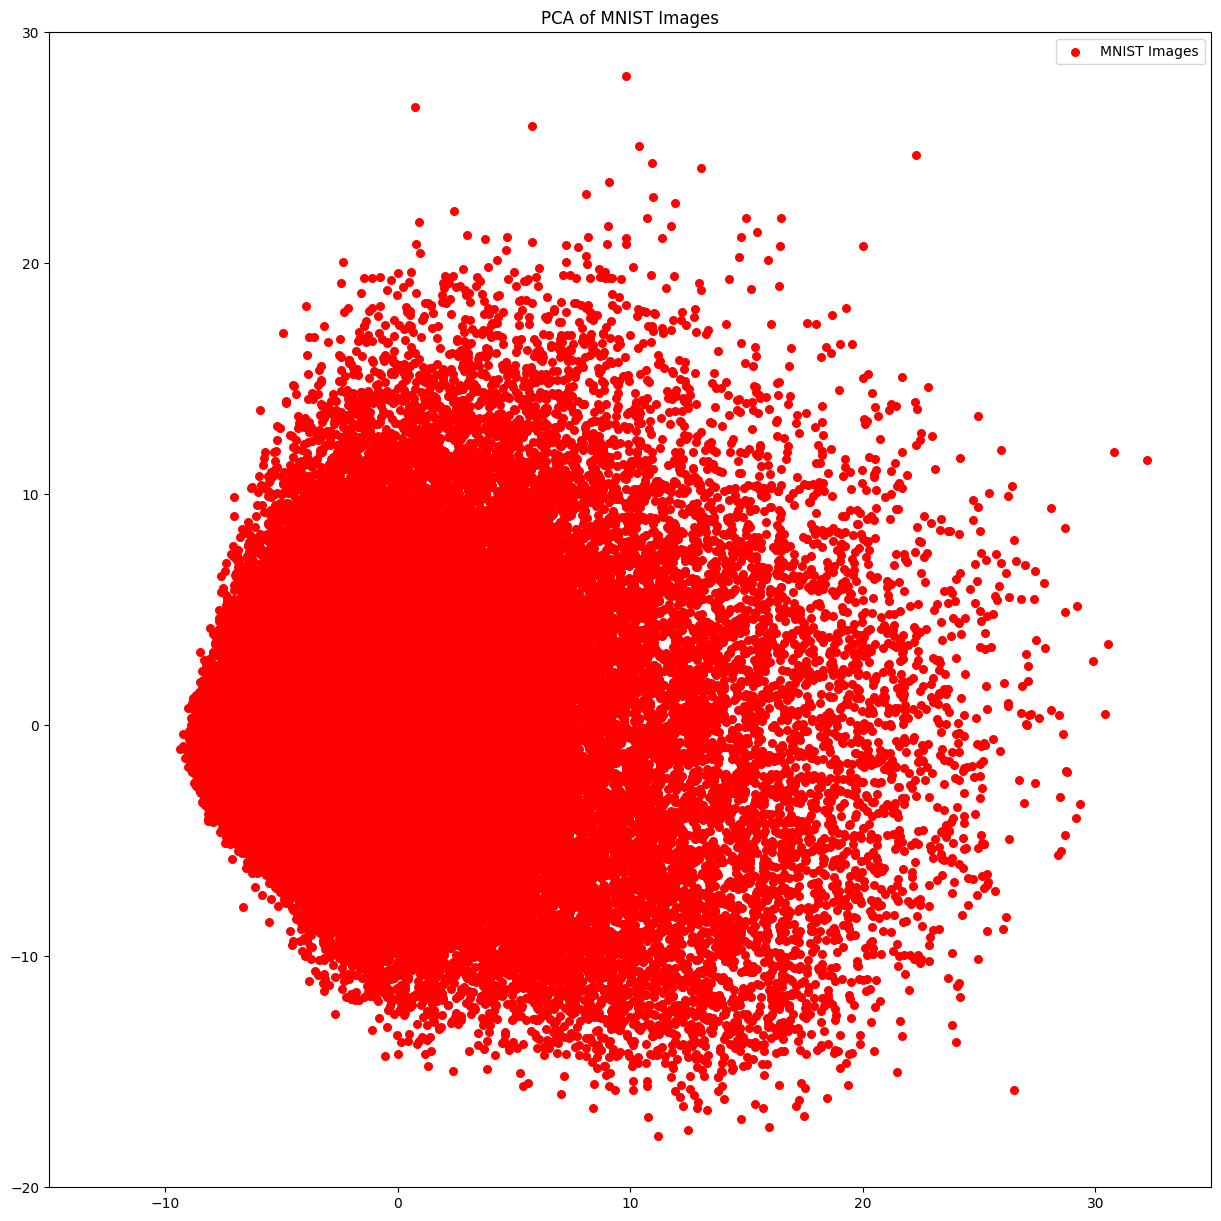

In [13]:
plt.scatter(mnist_images_pca[:, 0], mnist_images_pca[:, 1], s=30, c='red', label='MNIST Images')
plt.gcf().set_size_inches(15, 15)
plt.title('PCA of MNIST Images')
plt.xlim(-15, 35)
plt.ylim(-20, 30)
plt.legend()
plt.show()

In [12]:
images_path = '/Users/rezachi/Library/CloudStorage/OneDrive-TheUniversityofNottingham/Biomaterial/GAN results/logs/experiment11_WGAN_Mnist/images'
mnist_images_names = [
            Path(image).stem
            for image in glob.glob(
                os.path.join(images_path, "*.png")
            )
        ]
img_size = 28
seed = 1221
random.seed(seed)
np.random.seed(seed)
# Load all of the images and make them as a batch
minist_GAN_images = []
for image_name in mnist_images_names:
    image = cv2.imread(os.path.join(images_path, f"{image_name}.png"), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (img_size, img_size))
    minist_GAN_images.append(image)

minist_GAN_images = np.array(minist_GAN_images)

# Flatten the images
minist_GAN_images = minist_GAN_images.reshape(minist_GAN_images.shape[0], -1)

steps = [('scaling', StandardScaler()), ('pca', PCA(n_components=2))]
pipeline = Pipeline(steps)
mnist_GAN_images_pca = pipeline.fit_transform(minist_GAN_images)

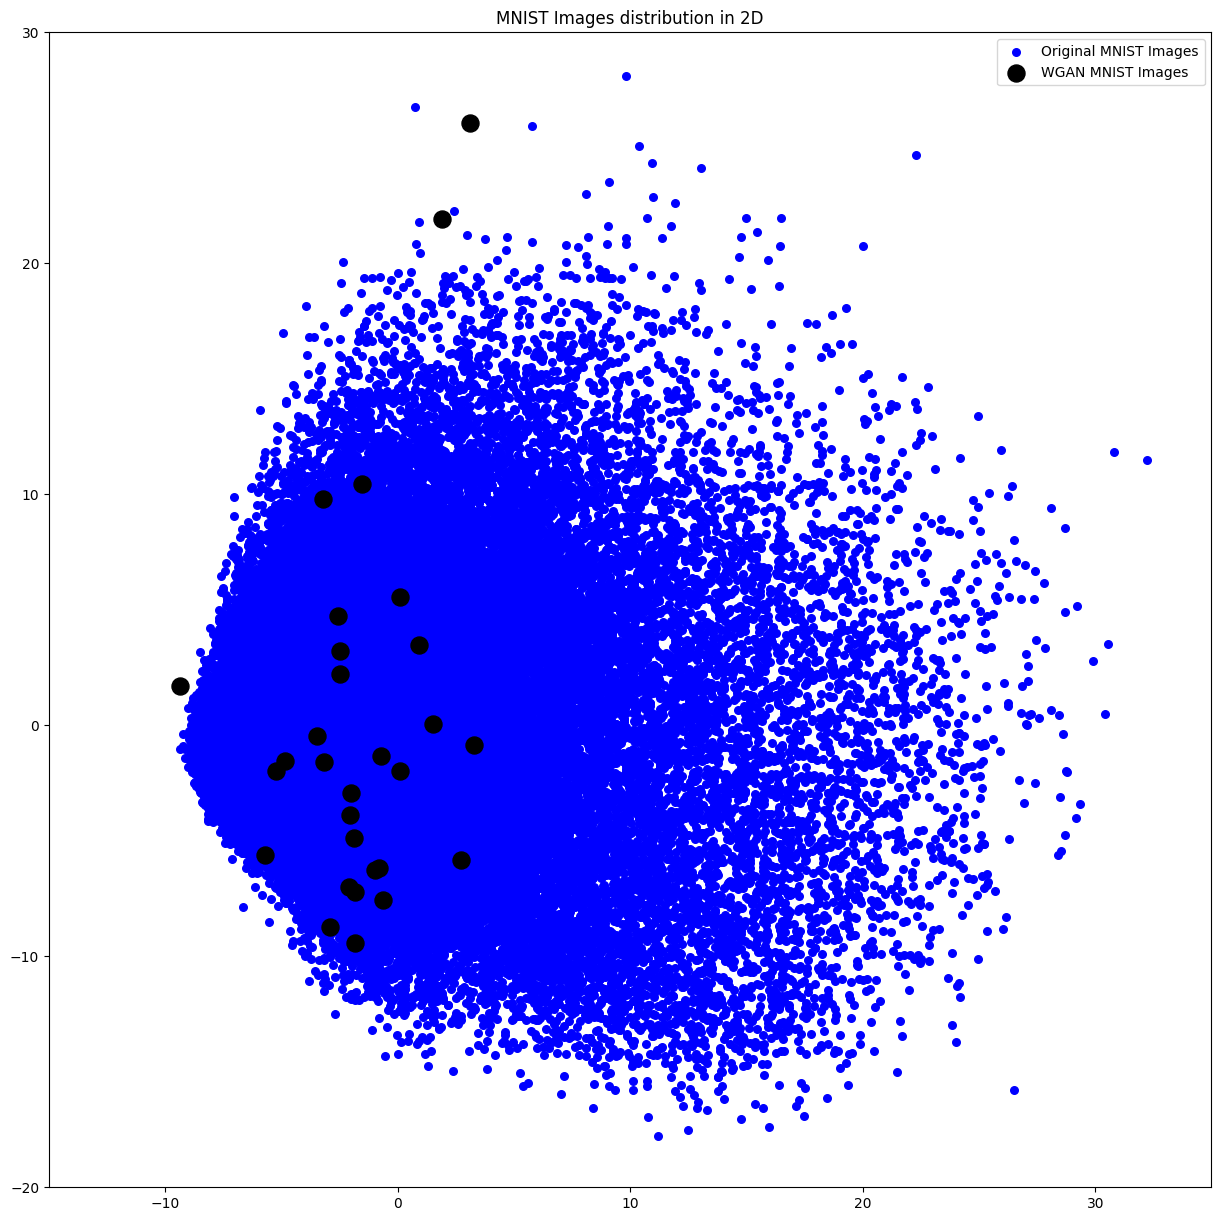

In [20]:
plt.scatter(mnist_images_pca[:, 0], mnist_images_pca[:, 1], s=30, c='blue', label='Original MNIST Images')
plt.scatter(mnist_GAN_images_pca[:, 0], mnist_GAN_images_pca[:, 1], s=150, c='black', label='WGAN MNIST Images')
plt.gcf().set_size_inches(15, 15)
plt.title('MNIST Images distribution in 2D')
plt.xlim(-15, 35)
plt.ylim(-20, 30)
plt.legend()
plt.show()

### TSNE

In [119]:
# perform t-SNE on the original images
tsne = TSNE(n_components=2, random_state=1221)
images_tsne = tsne.fit_transform(images)

# perform t-SNE on the interpolated images
tsne = TSNE(n_components=2, random_state=1221)
interp_images_tsne = tsne.fit_transform(interp_images)

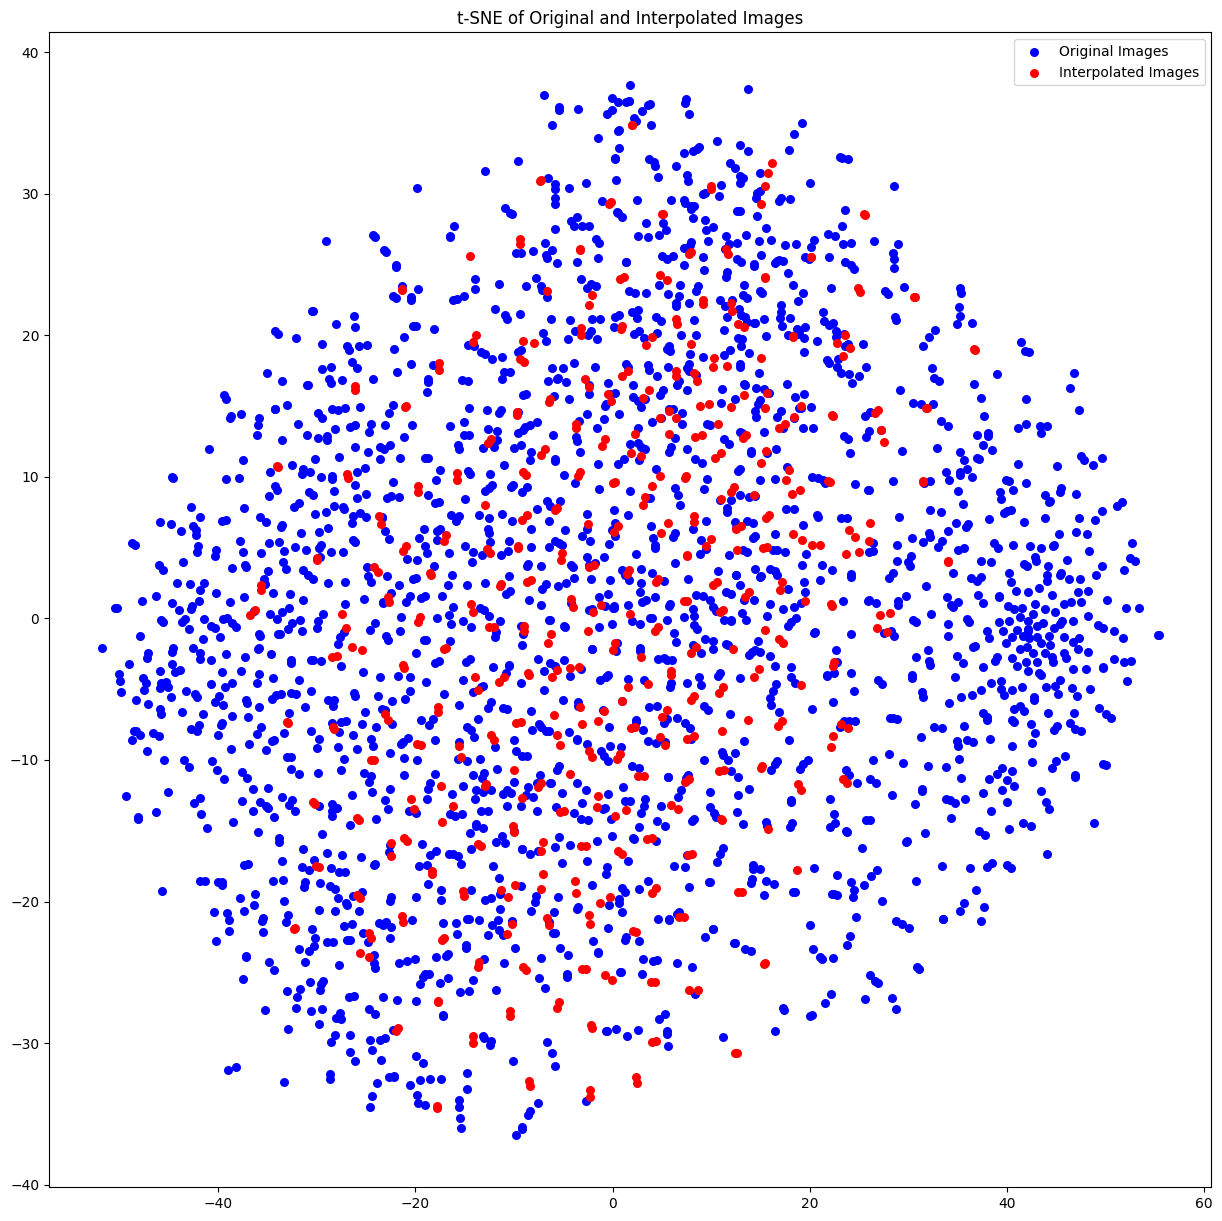

In [120]:
plt.scatter(images_tsne[:, 0], images_tsne[:, 1], s=30, c='blue', label='Original Images')
plt.scatter(interp_images_tsne[:, 0], interp_images_tsne[:, 1], s=30, c='red', label='Interpolated Images')
plt.gcf().set_size_inches(15, 15)
plt.title('t-SNE of Original and Interpolated Images')
plt.legend()
plt.show()

In [126]:
# StyleGAN images
images_path = '/Users/rezachi/Library/Mobile Documents/com~apple~CloudDocs/Business/UK/DRS/Biomaterial/repo/GANs/logs/experiment19_StyleGAN/images/train'
images_names = [
            Path(image).stem
            for image in glob.glob(
                os.path.join(images_path, "*.png")
            )
        ]
img_size = 224
seed = 1221
random.seed(seed)
np.random.seed(seed)
# Load all of the images and make them as a batch
style_images = []
for image_name in images_names:
    if int(image_name.split("_")[1]) < 60000:
        continue
    image = cv2.imread(os.path.join(images_path, f"{image_name}.png"), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (img_size, img_size))
    style_images.append(image)

style_images = np.array(style_images)

# Flatten the images
style_images = style_images.reshape(style_images.shape[0], -1)

steps = [('scaling', StandardScaler()), ('pca', PCA(n_components=2))]
pipeline = Pipeline(steps)
style_images_pca = pipeline.fit_transform(style_images)

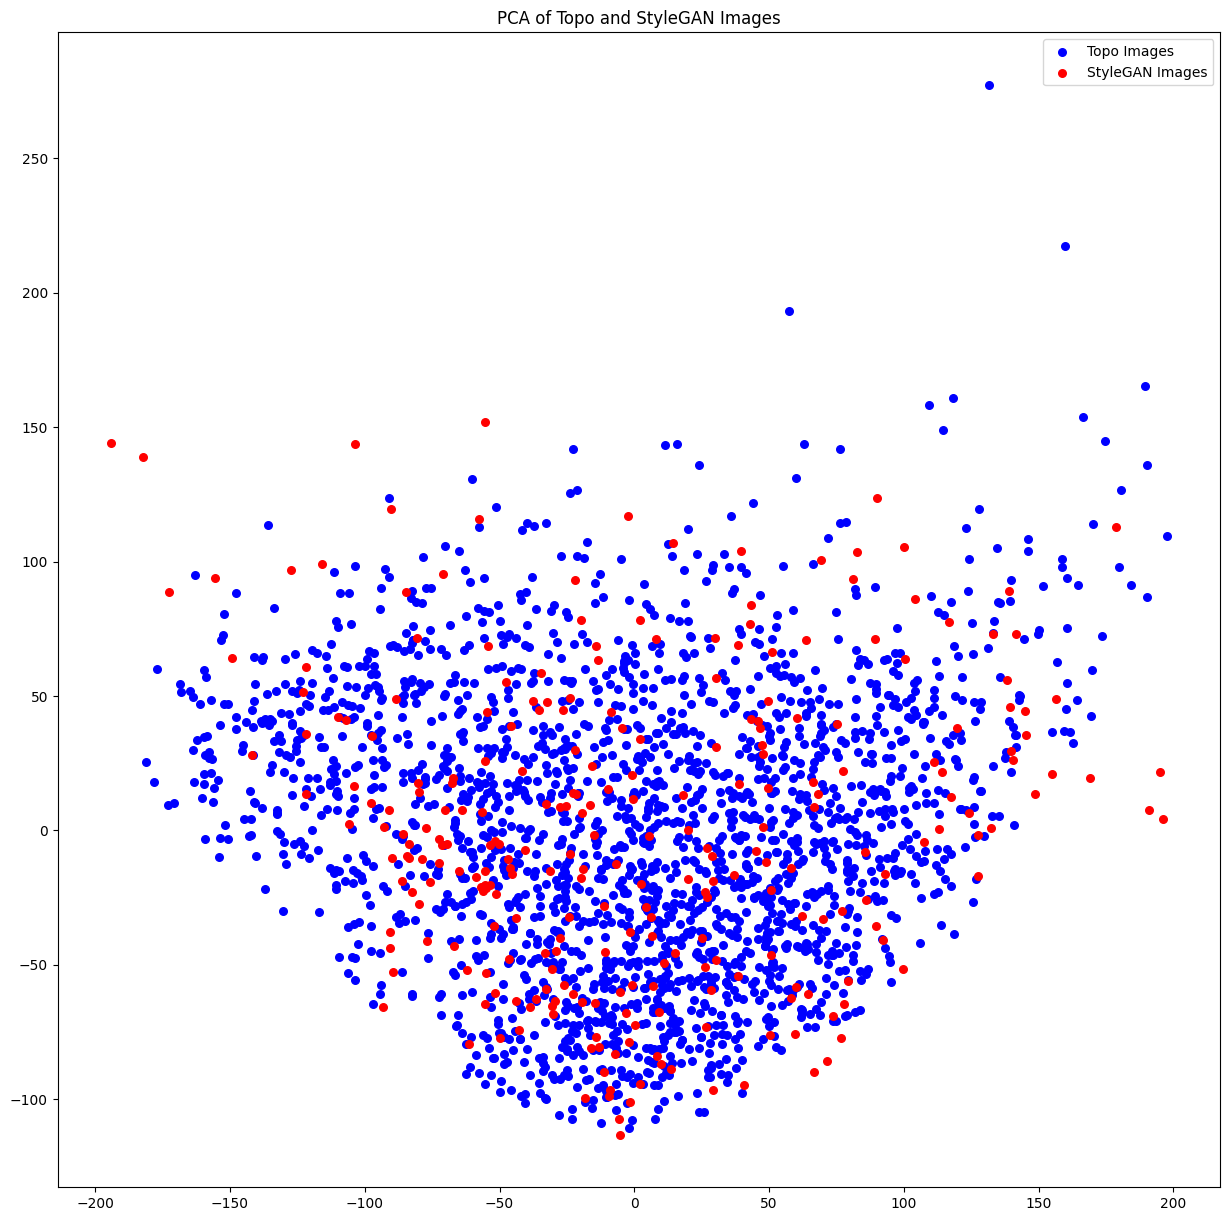

In [127]:
plt.scatter(images_pca[:, 0], images_pca[:, 1], s=30, c='blue', label='Topo Images')
plt.scatter(style_images_pca[:, 0], style_images_pca[:, 1], s=30, c='red', label='StyleGAN Images')
plt.gcf().set_size_inches(15, 15)
plt.title('PCA of Topo and StyleGAN Images')
plt.legend()
plt.show()

## Gaussian Blur

### Embossed Images

#### Using OpenCV

In [ ]:
import cv2
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import random

seed = 1221
random.seed(seed)

# Function to apply Gaussian Blur and Otsu Thresholding
def apply_blur_and_threshold(image_path, kernel_size=7):
    # Read the image
    img = cv2.imread(image_path, 0)

    # Apply Gaussian Blur
    blurred_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    # Apply Otsu Thresholding
    _, threshold_img = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return img, blurred_img, threshold_img

# Path to the folder containing images
folder_path = "/Users/rezachi/Library/Mobile Documents/com~apple~CloudDocs/Business/UK/DRS/Biomaterial/repo/Datasets/Topographies/raw/FiguresStacked 8X8"
embosed_path = "/USers/rezachi/Library/Mobile Documents/com~apple~CloudDocs/Business/UK/DRS/Biomaterial/repo/Datasets/Topographies/raw/FiguresStacked 8X8 Embossed"

# Get a list of image files from the folder
image_files = os.listdir(folder_path)

# Randomly select 3 images
selected_images = random.sample(image_files, 3)
kernel_size = 41

# Plot original image, blurred image, and thresholded image for each selected image
for image_file in selected_images:
    # Get file path
    image_path = os.path.join(folder_path, image_file)
    embossed_path = os.path.join(embosed_path, image_file)

    # Apply blur and threshold
    original_img, blurred_img, threshold_img = apply_blur_and_threshold(image_path, kernel_size)
    embossed_img = cv2.imread(embossed_path, 0)

    # Plot images
    plt.figure(figsize=(20, 20))

    plt.subplot(2, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')

    plt.subplot(2, 2, 2)
    plt.imshow(blurred_img, cmap='gray')
    plt.title('Blurred Image')

    plt.subplot(2, 2, 3)
    plt.imshow(embossed_img, cmap='gray')
    plt.title('Embossed Image')

    plt.subplot(2, 2, 4)
    plt.imshow(threshold_img, cmap='gray')
    plt.title('Thresholded Image')

    plt.show()


#### Using PyTorch

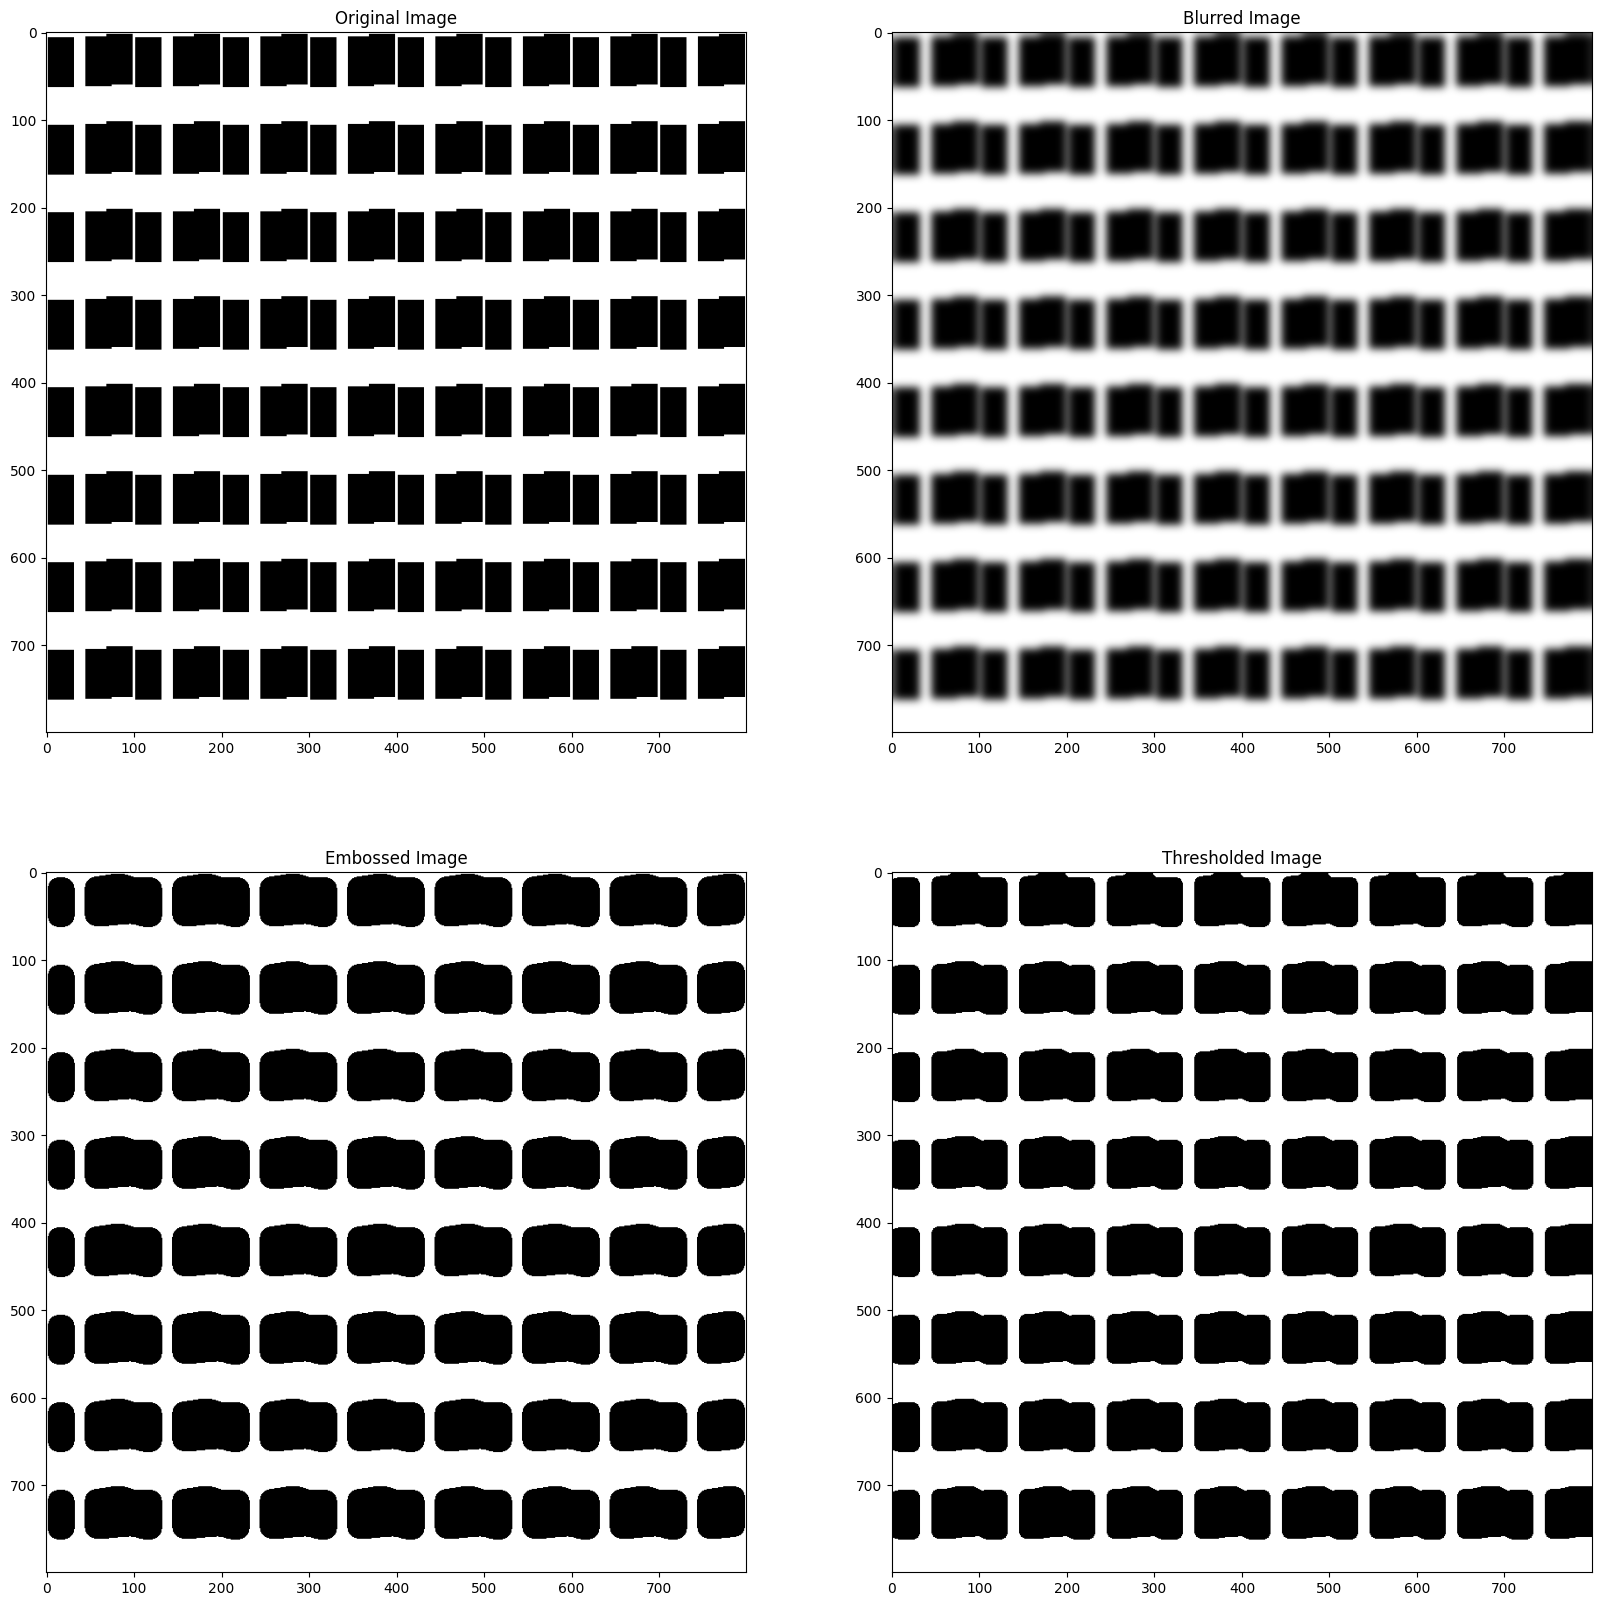

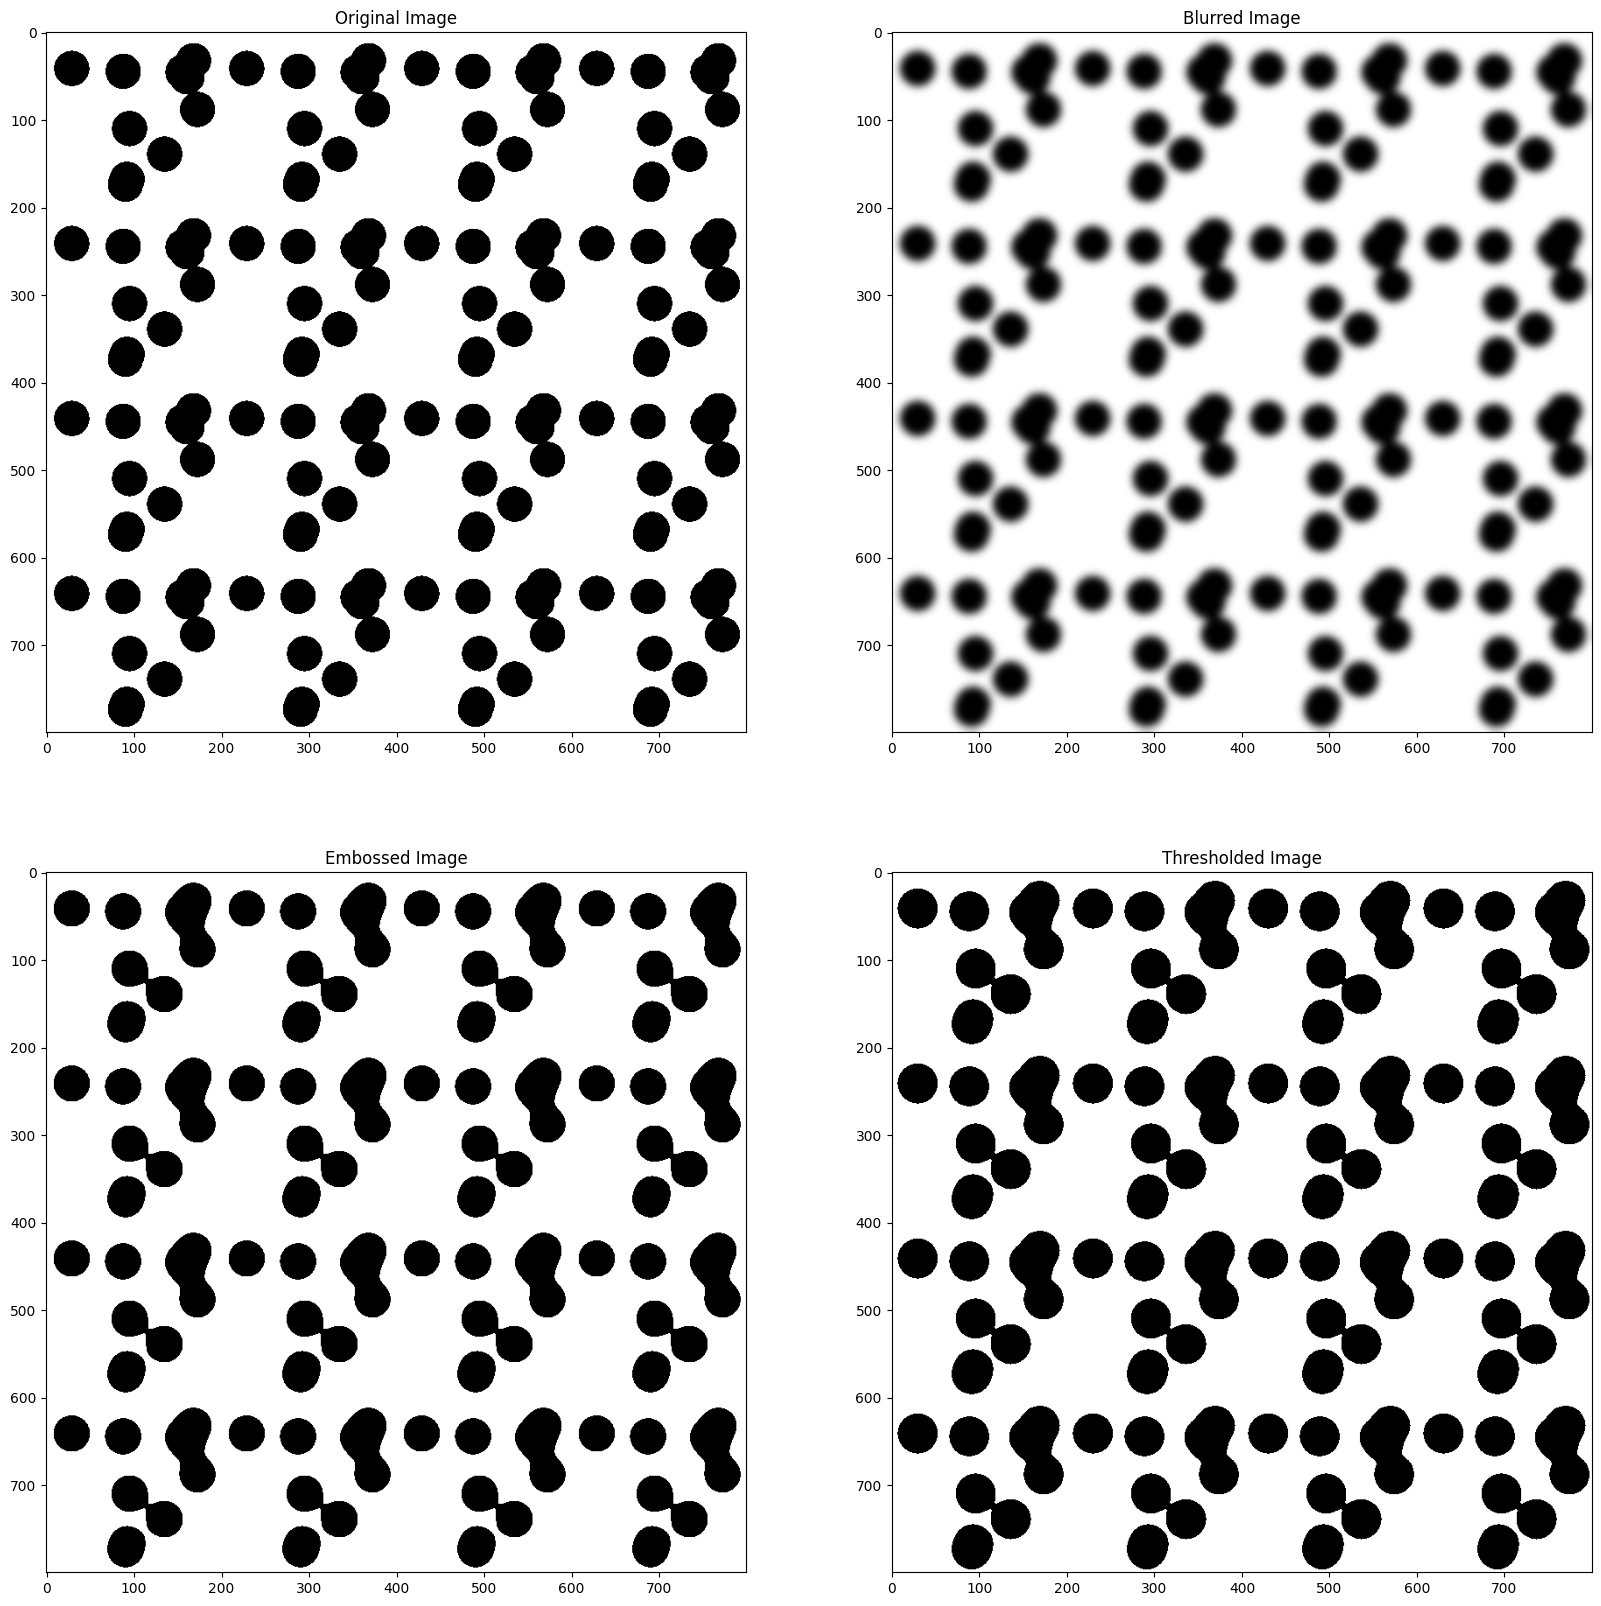

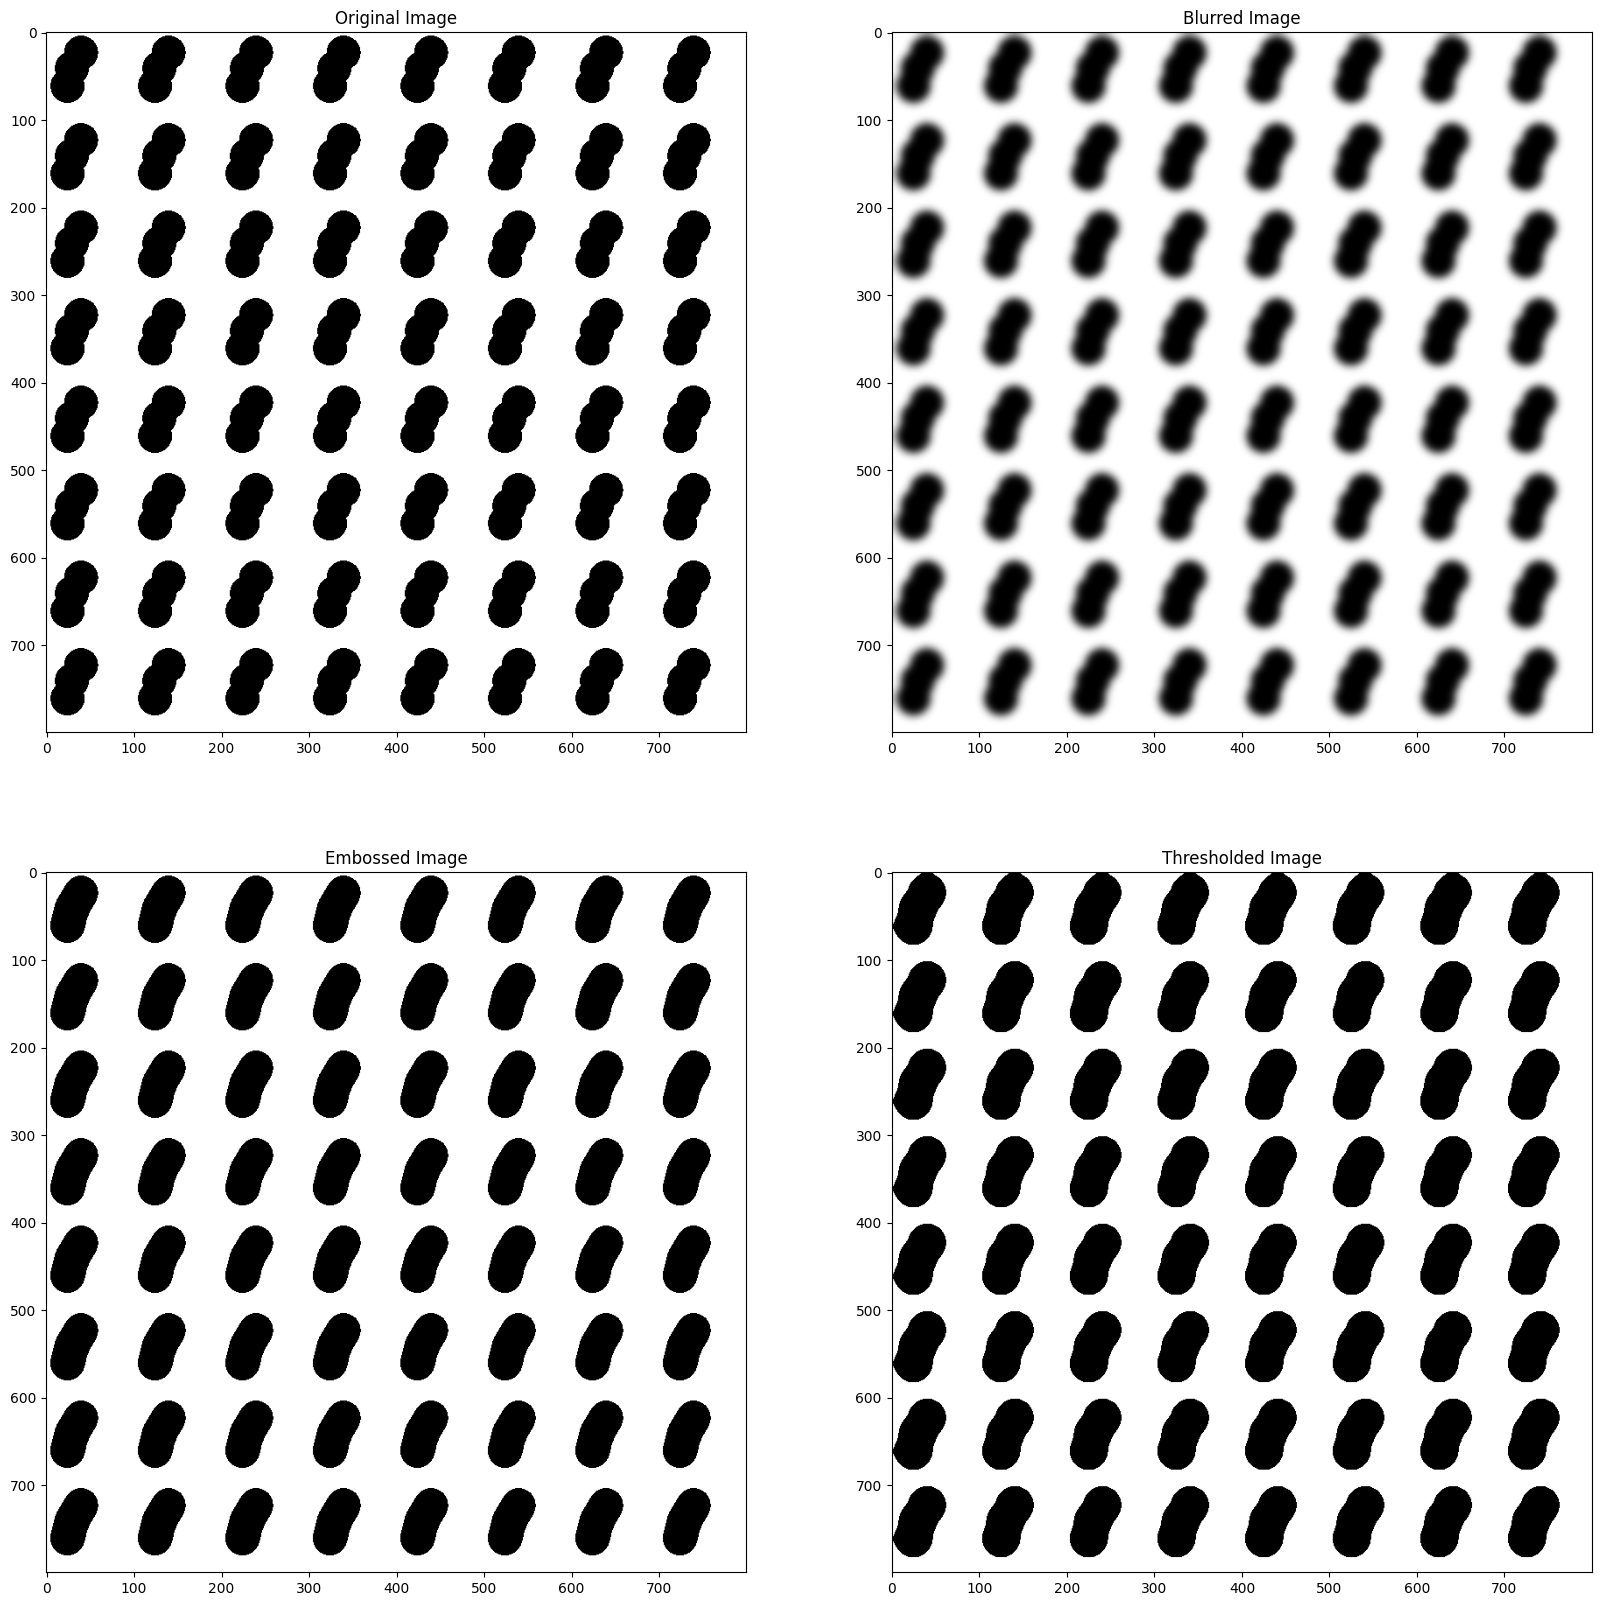

In [5]:
import os
import random
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image


# Function to apply Gaussian Blur and Otsu Thresholding
def apply_blur_and_threshold(image, kernel_size=7, sigma=None):
    # Apply Gaussian Blur
    blurred_img = TF.gaussian_blur(image, kernel_size=kernel_size, sigma=sigma)

    # Convert to grayscale
    blurred_img = blurred_img.mean(dim=0, keepdim=True)

    # Apply Otsu Thresholding
    threshold_img = (blurred_img > blurred_img.mean()).float() * 255

    return blurred_img, threshold_img

# Path to the folder containing images
folder_path = "/Users/rezachi/Library/Mobile Documents/com~apple~CloudDocs/Business/UK/DRS/Biomaterial/repo/Datasets/Topographies/raw/FiguresStacked 8X8"

# Get a list of image files from the folder
image_files = os.listdir(folder_path)

# Randomly select 3 images
selected_images = random.sample(image_files, 3)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

kernel_size = 29
sigma = None

# Plot original image, blurred image, and thresholded image for each selected image
for image_file in selected_images:
    # Get file path
    image_path = os.path.join(folder_path, image_file)
    embossed_path = os.path.join(embosed_path, image_file)

    # Read the image
    original_img = Image.open(image_path).convert('L')
    embossed_img = cv2.imread(embossed_path, 0)

    # Apply transformations
    image = transform(original_img)

    # Apply blur and threshold
    blurred_img, threshold_img = apply_blur_and_threshold(image, kernel_size, sigma)

    # Plot images
    plt.figure(figsize=(20, 20))

    plt.subplot(2, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')

    plt.subplot(2, 2, 2)
    plt.imshow(blurred_img.squeeze().cpu().numpy(), cmap='gray')
    plt.title('Blurred Image')

    plt.subplot(2, 2, 3)
    plt.imshow(embossed_img, cmap='gray')
    plt.title('Embossed Image')

    plt.subplot(2, 2, 4)
    plt.imshow(threshold_img.squeeze().cpu().numpy(), cmap='gray')
    plt.title('Thresholded Image')

    plt.show()


### Generated Embossed Images

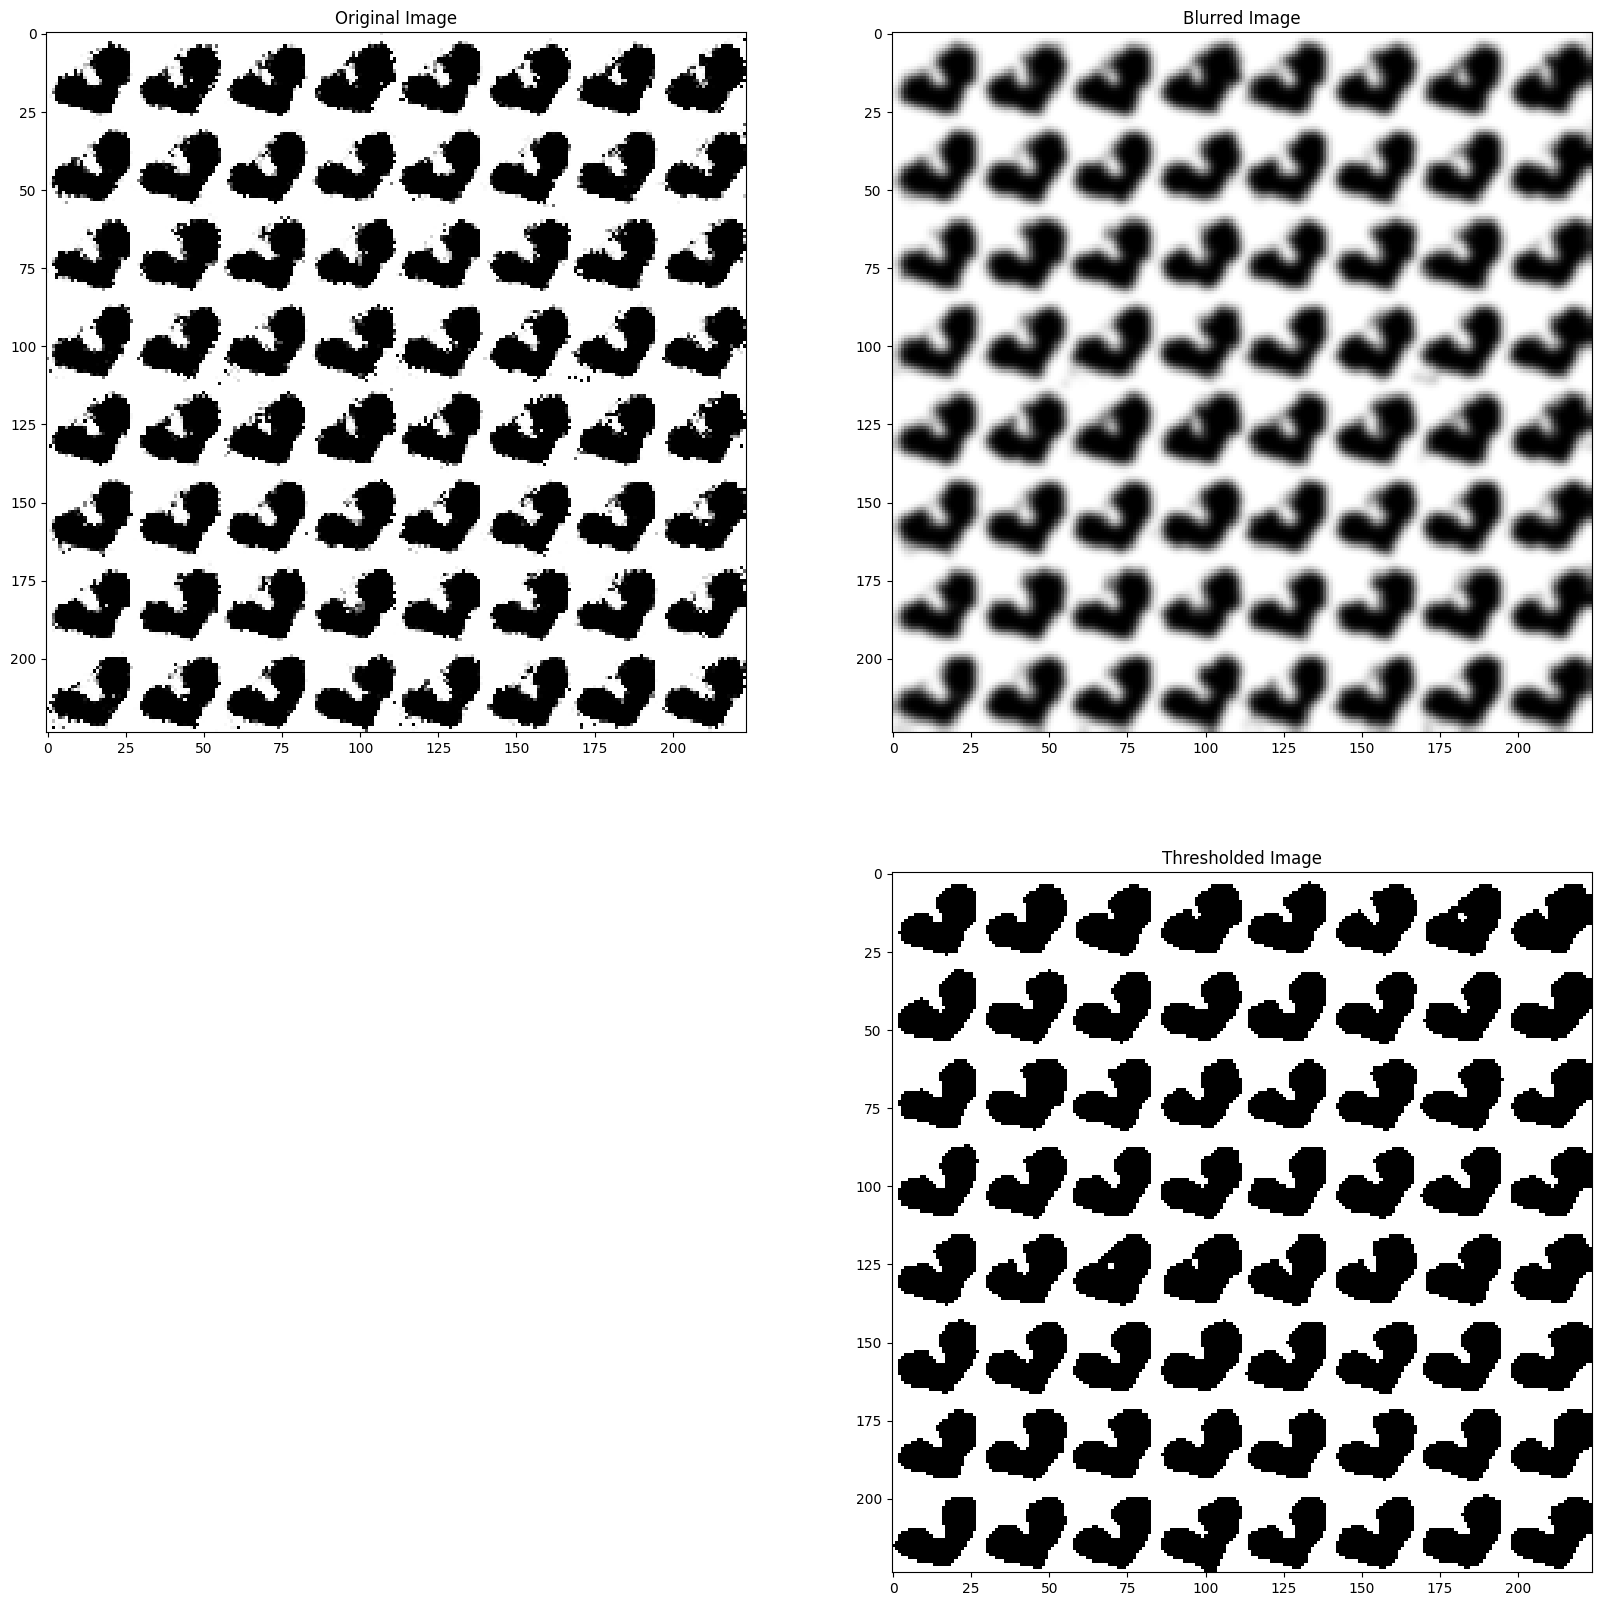

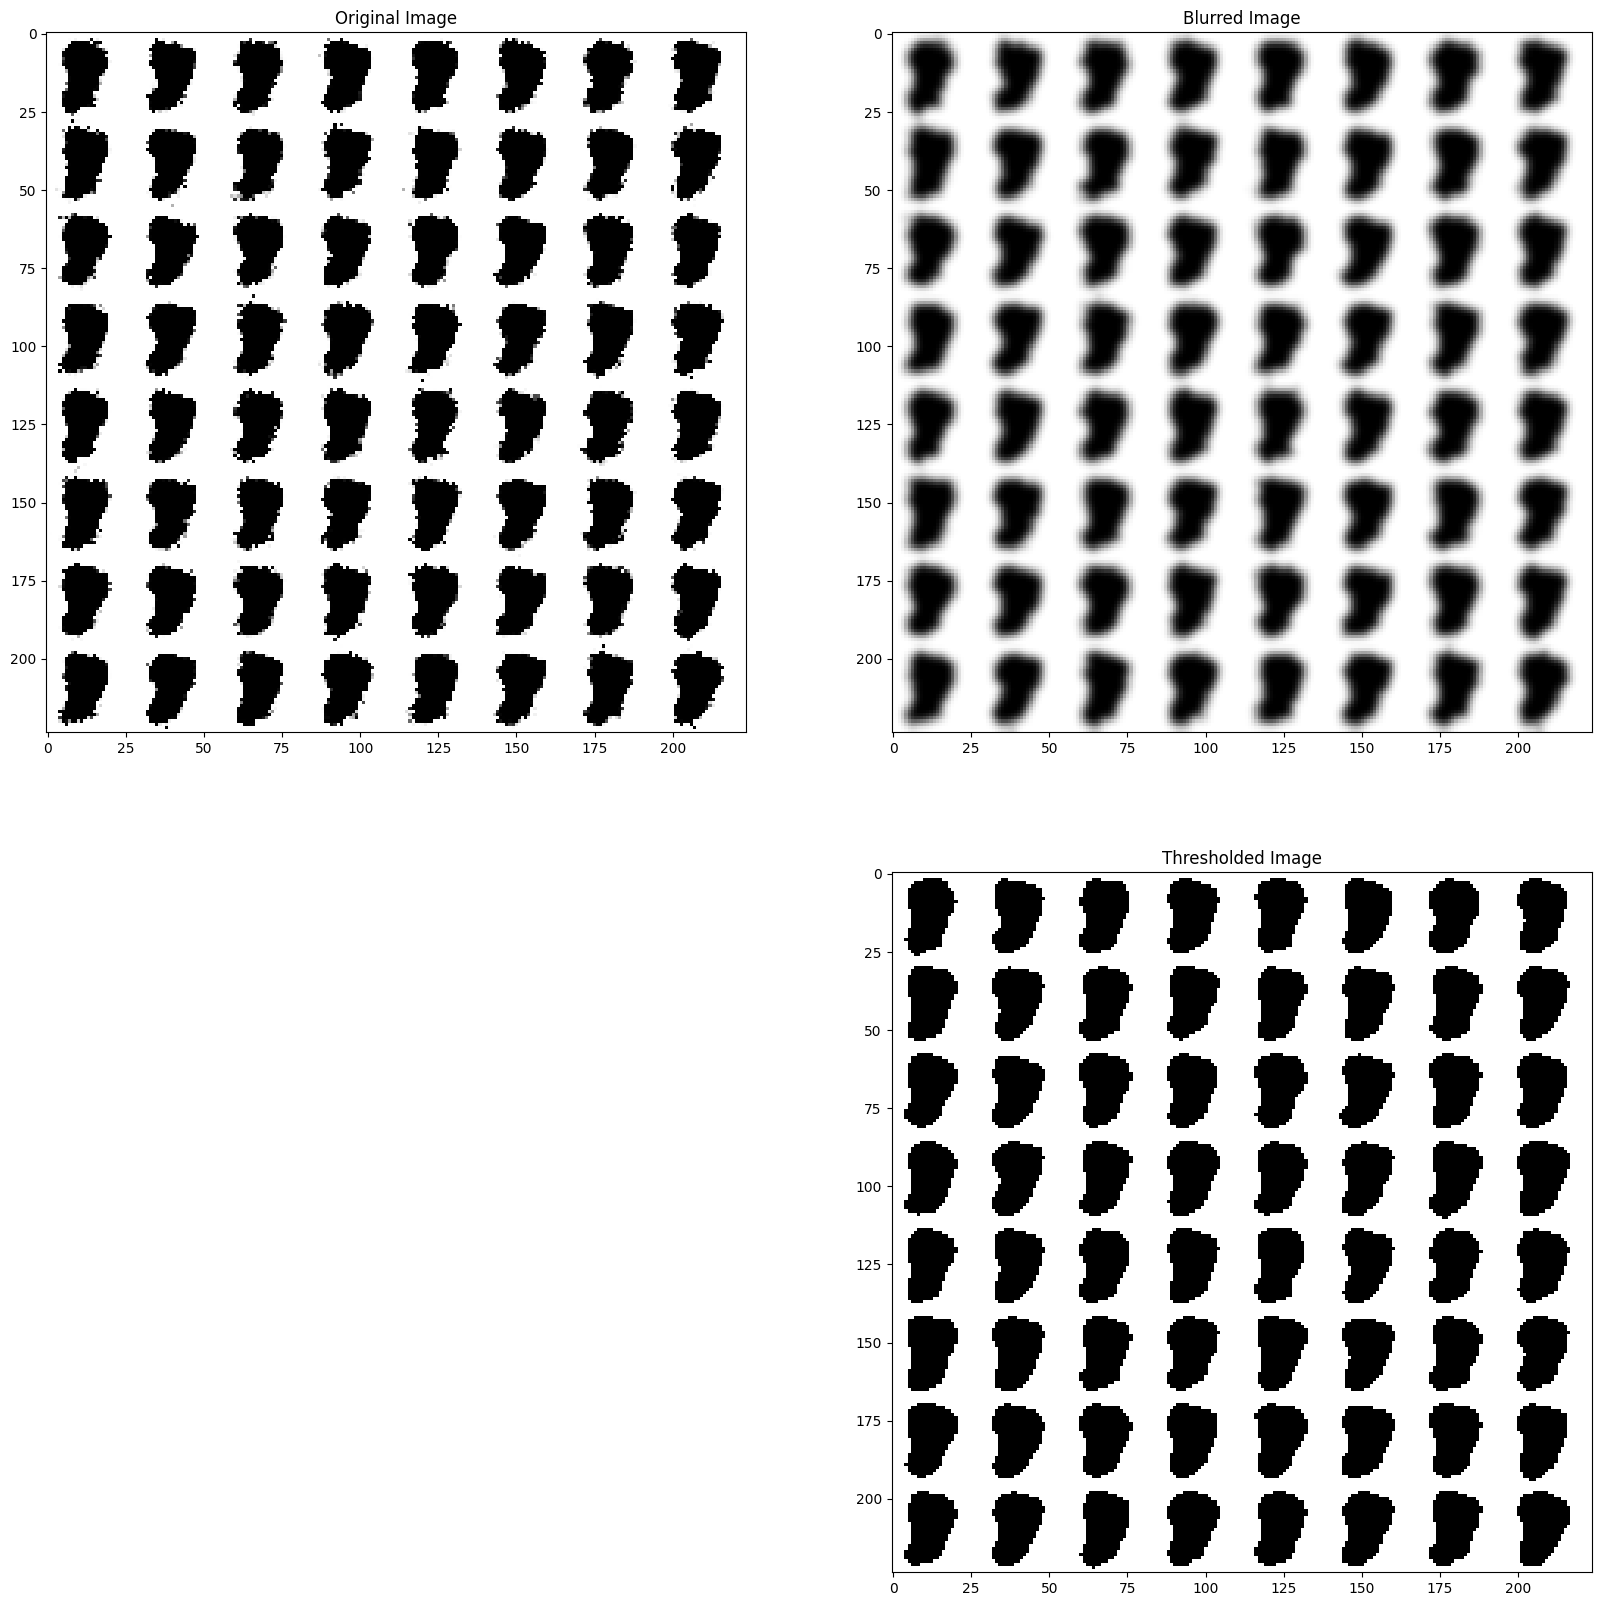

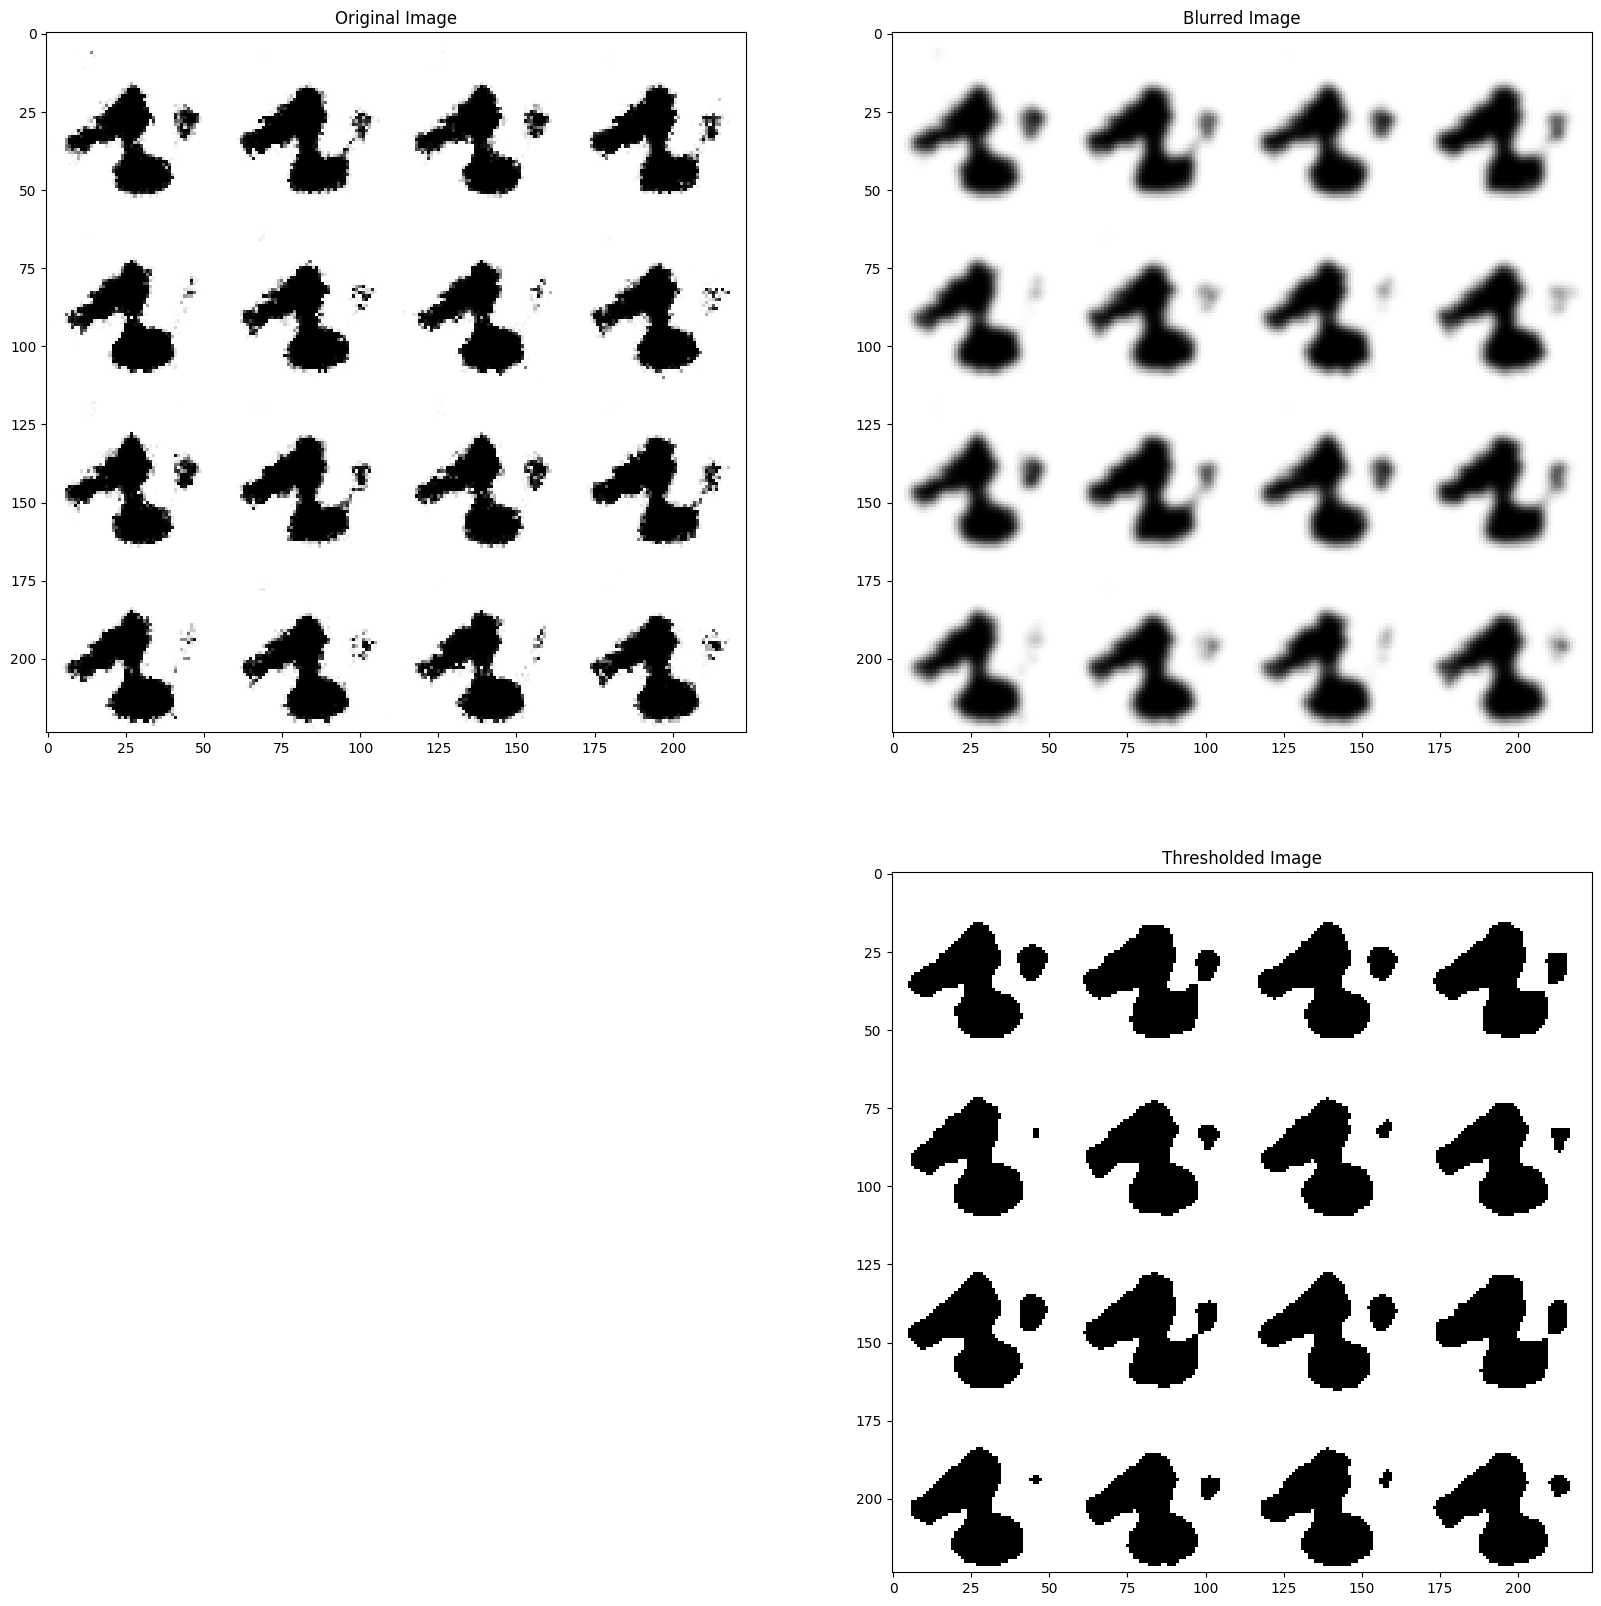

In [6]:
import os
import random
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image

# Function to apply Gaussian Blur and Otsu Thresholding
def apply_blur_and_threshold(image, kernel_size=7):
    # Apply Gaussian Blur
    blurred_img = TF.gaussian_blur(image, kernel_size=kernel_size)

    # Convert to grayscale
    blurred_img = blurred_img.mean(dim=0, keepdim=True)

    # Apply Otsu Thresholding
    threshold_img = (blurred_img > blurred_img.mean()).float() * 255

    return blurred_img, threshold_img

# Path to the folder containing images
folder_path = "/Users/rezachi/Library/CloudStorage/OneDrive-TheUniversityofNottingham/Biomaterial/GAN results/logs/experiment23_WGAN_GP_embossed/images/train"

# Get a list of image files from the folder
image_files = os.listdir(folder_path)
image_files = [image for image in image_files if int(image.split('_')[1]) > 12500]

# Randomly select 3 images
selected_images = random.sample(image_files, 3)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

kernel_size = 7

# Plot original image, blurred image, and thresholded image for each selected image
for image_file in selected_images:
    # Get file path
    image_path = os.path.join(folder_path, image_file)

    # Read the image
    original_img = Image.open(image_path).convert('L')

    # Apply transformations
    image = transform(original_img)

    # Apply blur and threshold
    blurred_img, threshold_img = apply_blur_and_threshold(image, kernel_size)

    # Plot images
    plt.figure(figsize=(20, 20))

    plt.subplot(2, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')

    plt.subplot(2, 2, 2)
    plt.imshow(blurred_img.squeeze().cpu().numpy(), cmap='gray')
    plt.title('Blurred Image')

    plt.subplot(2, 2, 4)
    plt.imshow(threshold_img.squeeze().cpu().numpy(), cmap='gray')
    plt.title('Thresholded Image')

    plt.show()


## Predicted Images Similarity

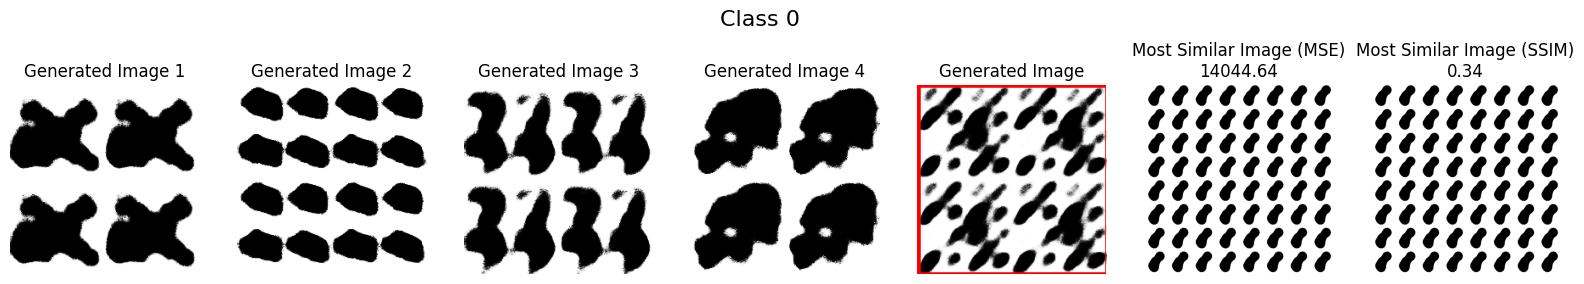

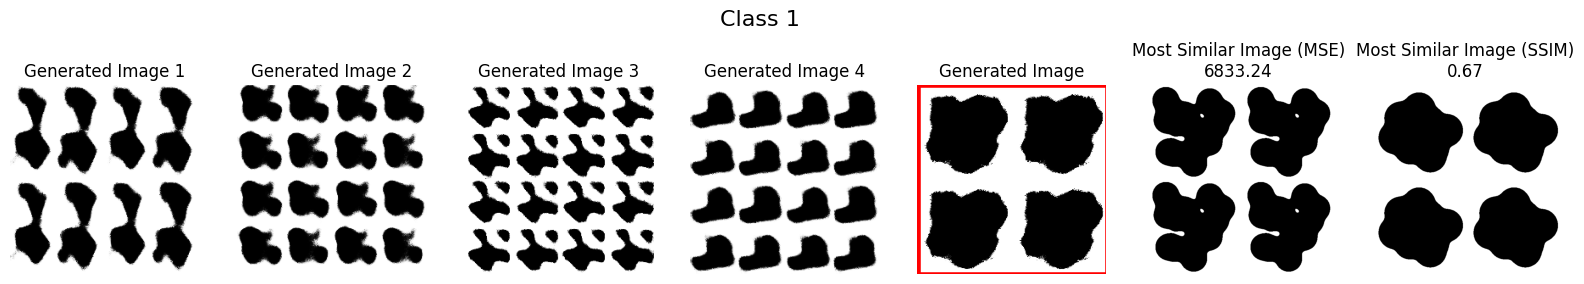

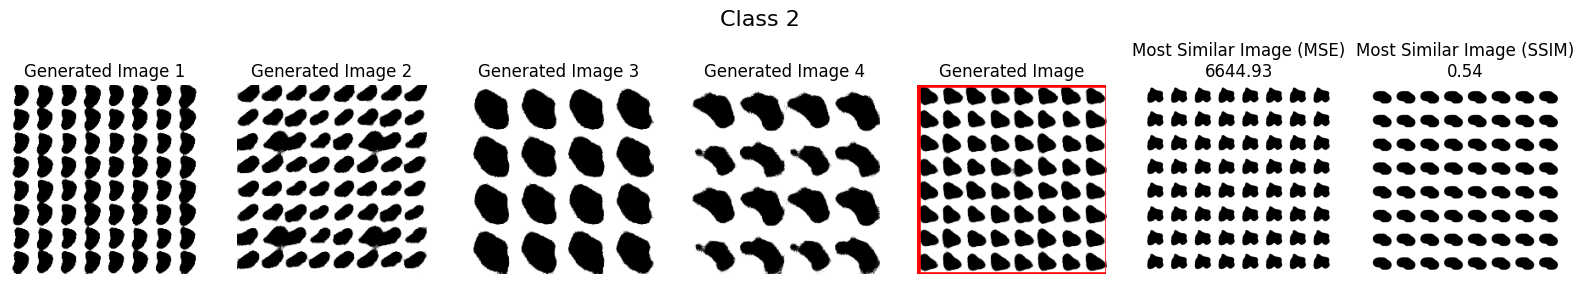

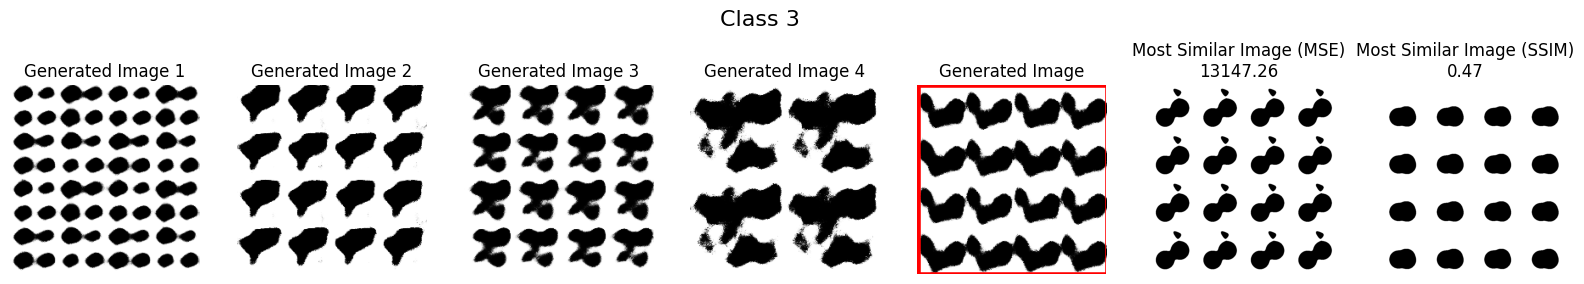

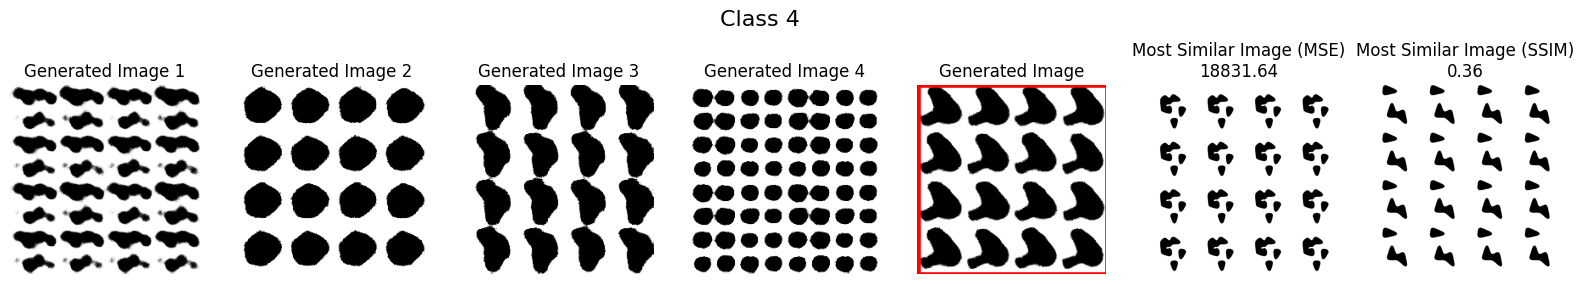

In [87]:
import glob
import os
import random
import pandas as pd
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


predicted_images_path = '/Users/rezachi/Library/CloudStorage/OneDrive-TheUniversityofNottingham/Biomaterial/GAN results/logs/prediction_ACBlurGAN/images/test'
training_images_path = '/Users/rezachi/Library/Mobile Documents/com~apple~CloudDocs/Business/UK/DRS/Biomaterial/repo/Datasets/Topographies/raw/FiguresStacked 8X8 Embossed'
label_path = '/Users/rezachi/Library/Mobile Documents/com~apple~CloudDocs/Business/UK/DRS/Biomaterial/repo/Datasets/biology_data/TopoChip/AeruginosaWithClass.csv'

labels_to_vis = [0, 1, 2, 3, 4]
num_images = 5
figure_width = 20
figure_height = 3.5

for label_to_vis in labels_to_vis:
    # Get the latest predicted image for the current label
    predicted_images_list = [
        image
        for image in glob.glob(
            os.path.join(predicted_images_path, "*.png")
        ) if int(image.split("/")[-1].split("_")[1]) == label_to_vis
    ]
    predicted_images_list = random.sample(predicted_images_list, num_images)
    if predicted_images_list:
        predicted_img_path = predicted_images_list[-1]
    else:
        print(f"No predicted image found for label {label_to_vis}")
        continue

    # Load the latest predicted image and convert it to grayscale
    generated_img = Image.open(predicted_img_path).convert('L')
    generated_tensor = torch.tensor(np.array(generated_img), dtype=torch.float)

    # Get training images for the current label
    training_labels = pd.read_csv(label_path)
    training_labels = training_labels[training_labels["class"] == label_to_vis]
    training_images_list = [
        image
        for image in glob.glob(
            os.path.join(training_images_path, "*.png")
        ) if int(image.split("/")[-1].split("_")[2]) in training_labels["FeatID"].values
    ]

    # Compute pixel-wise similarity metrics (MSE and SSIM) with each training image
    mse_scores = []
    ssim_scores = []
    for img_path in training_images_list:
        train_img = Image.open(img_path).convert('L')
        train_img = train_img.resize(generated_img.size)
        train_tensor = torch.tensor(np.array(train_img), dtype=torch.float)

        mse = F.mse_loss(generated_tensor, train_tensor)
        mse_scores.append(mse.item())

        ssim_score = ssim(np.array(generated_img), np.array(train_img))
        ssim_scores.append(ssim_score)

    # Find the index of the training image with the lowest MSE or highest SSIM
    most_similar_index_mse = mse_scores.index(min(mse_scores))
    most_similar_image_path_mse = training_images_list[most_similar_index_mse]

    most_similar_index_ssim = ssim_scores.index(max(ssim_scores))
    most_similar_image_path_ssim = training_images_list[most_similar_index_ssim]

    # Plotting
    plt.figure(figsize=(figure_width, figure_height))
    num_plots = num_images+2
    for i in range(num_plots):
        if i < num_images-1:
            img = Image.open(predicted_images_list[i]).convert('L')
            plt.subplot(1, num_plots, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(f'Generated Image {i+1}')
            plt.axis('off')
        elif i == num_images-1:
            ax = plt.subplot(1, num_plots, i+1)
            plt.imshow(generated_img, cmap='gray')
            plt.title('Generated Image')
            plt.axis('off')   
            rect = patches.Rectangle((0,0),225,225,linewidth=4,edgecolor='r',facecolor='none')
            ax.add_patch(rect)  # Add the red rectangle
        elif i == num_images:
            plt.subplot(1, num_plots, i+1)
            plt.imshow(Image.open(most_similar_image_path_mse).convert('L'), cmap='gray')
            plt.title(f'Most Similar Image (MSE)\n{mse_scores[most_similar_index_mse]:.2f}')
            plt.axis('off')
        else:
            plt.subplot(1, num_plots, i+1)
            plt.imshow(Image.open(most_similar_image_path_ssim).convert('L'), cmap='gray')
            plt.title(f'Most Similar Image (SSIM)\n{ssim_scores[most_similar_index_ssim]:.2f}')
            plt.axis('off')
    plt.suptitle(f"Class {label_to_vis}", fontsize=16)
    plt.show()


## HP Optimization

In [18]:
import glob
import os
import json
import pandas as pd
import plotly.express as px


hp_optimisation_path = '/Users/rezachi/Library/CloudStorage/OneDrive-TheUniversityofNottingham/Biomaterial/GAN results/logs/hp-optimisation_2024-06-25_21-15-01'
best_fid_files = [
    file
    for file in glob.glob(
        os.path.join(hp_optimisation_path, "*.json")
    ) if "best_fid" in file
]

df_list = []
fid_scores = pd.DataFrame()
for file in best_fid_files:
    model_name = file.split("/")[-1].split("_")[0]
    with open(file, 'r') as f:
        fid_score = round(json.load(f), 2)
    df_list.append(pd.DataFrame({"model_name": [model_name], "fid_score": [fid_score]}))

fid_scores = pd.concat(df_list, ignore_index=True)
fid_scores_sorted = fid_scores.sort_values(by='fid_score', ascending=False)

fig = px.bar(fid_scores_sorted, x='fid_score', y='model_name', orientation='h',
             title='FID Scores of Different GAN Models',
             labels={'fid_score': 'FID Score', 'model_name': 'Model Name'},
             color='fid_score', color_continuous_scale='Viridis')
fig.update_layout(title_x=0.5)
fig.show()
